# **Benchmark Analysis for Hazard and Product Prediction Using CatBoost**

## **Introduction**

### **Purpose of the Analysis**
The objective of this notebook is to evaluate the performance of the **CatBoost** algorithm in predicting food-related **hazard categories** and **product categories**. This is a continuation of our efforts to identify the best-performing models for food hazard detection, with a specific focus on leveraging **CatBoost's capabilities** for handling categorical data effectively.

### **Why CatBoost?**
CatBoost is a gradient boosting algorithm specifically optimized for categorical features, making it particularly suitable for this task. It is known for:
- Handling imbalanced datasets efficiently.
- Incorporating categorical data directly without preprocessing.
- Offering fast training with GPU support.
- Providing robust feature importance insights for interpretability.

### **Scope of the Notebook**
This notebook aims to address the following subtasks using **CatBoost**:
1. **Subtask 1**: Predicting high-level **hazard categories** and **product categories** from **titles** and **text**.
2. **Subtask 2**: Predicting detailed **hazard vectors** and **product vectors**.

### **Approach**
1. **Data Preparation**:
   - Extract and preprocess features from the **title** and **text** columns.
   - Address class imbalance by setting class weights for training.

2. **Model Training and Evaluation**:
   - Train separate **CatBoost models** for Subtask 1 and Subtask 2 on both **text** and **title** data.
   - Evaluate models using **macro F1 scores** to ensure balanced performance across all classes.

3. **Visualization**:
   - Analyze feature importance to understand the contribution of specific features to the predictions.
   - Visualize combined F1 scores for subtasks using bar charts to compare the performance of title-based and text-based approaches.

### **Significance of the Analysis**
Food hazard detection is a critical task in ensuring public health and safety. The findings from this notebook will:
- Highlight the effectiveness of **CatBoost** in this domain.
- Provide a comparison with previous models (e.g., Logistic Regression) to assess whether advanced machine learning algorithms offer significant improvements.
- Offer insights into feature importance for better interpretability and model refinement.

### **Outcome**
By the end of this notebook, we will have a clear understanding of:
- How well **CatBoost** performs on hazard and product prediction tasks.
- The comparative performance of **title-based** versus **text-based** predictions.
- Actionable insights for improving food safety risk detection using machine learning.




#### Loading and installation of Libraries


In [ ]:
!pip install catboost
!pip install pandas
!pip install scikit-learn

In [ ]:

# Load required libraries
import pandas as pd # Pandas: For data loading and manipulation

# Scikit-learn: For TF-IDF, model building, and evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from IPython.display import display # Display the TF-IDF DataFrames
# Import required libraries

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import ListedColormap
# Setting seed for reproducibility
np.random.seed(42)
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
from catboost import CatBoostClassifier

### **Loading the Dataset**

The datasets used in this analysis are loaded as follows:

- `train_data`: Contains the **cleaned training data** with both text and title features, along with corresponding labels for hazard and product categories. This dataset will be used to train the **CatBoost** models.
- `validation_data`: Contains the **cleaned validation data**, which includes text and title features without labels. This dataset will be used to evaluate the performance of the trained models and generate predictions.



In [ ]:
train_data = pd.read_csv('cleaned_train_data.csv')
validation_data = pd.read_csv('cleaned_validation_data.csv')

### TF-IDF Feature Extraction for Text and Titles

To prepare the textual data for machine learning models, we extract **TF-IDF (Term Frequency-Inverse Document Frequency)** features from both the `text` and `title` columns. This step transforms the raw text into numerical vectors, enabling machine learning algorithms to process the data.

#### Steps Performed:
1. **Data Extraction**:
   - **Text Data**: Extracted from the `text` column of both `train_data` and `validation_data`.
   - **Title Data**: Extracted from the `title` column of both `train_data` and `validation_data`.

2. **TF-IDF Vectorization**:
   - **Text Vectorizer**:
     - Maximum Features: 200
     - Captures the top 200 most informative terms based on TF-IDF scores in the `text` column.
   - **Title Vectorizer**:
     - Maximum Features: 50
     - Captures the top 50 most informative terms based on TF-IDF scores in the `title` column.

3. **Fitting and Transforming**:
   - **Training Data**:
     - TF-IDF vectorizers are fitted on the training data (`train_data`) for both `text` and `title`.
     - The resulting TF-IDF matrices are converted to pandas DataFrames for better interpretability.
   - **Validation Data**:
     - The fitted TF-IDF vectorizers are applied to the `validation_data` to ensure consistency between training and validation features.

4. **DataFrames for TF-IDF Features**:
   - **Training DataFrames**:
     - `text_tfidf_df`: TF-IDF features for `text` column in training data.
     - `title_tfidf_df`: TF-IDF features for `title` column in training data.
   - **Validation DataFrames**:
     - `val_text_tfidf_df`: TF-IDF features for `text` column in validation data.
     - `val_title_tfidf_df`: TF-IDF features for `title` column in validation data.

#### Why Use TF-IDF?
- **Importance of Words**: TF-IDF highlights words that are important within a specific document but not frequent across all documents.
- **Dimensionality Reduction**: By limiting the features to 200 (text) and 50 (title), we retain only the most informative terms, reducing computational overhead.
- **Consistency Across Datasets**: Using the same vectorizers ensures that the same vocabulary is used for both training and validation datasets.

#### Next Steps:
- The extracted TF-IDF features will be used as input for machine learning models to predict various labels (hazard category, product category, hazard vector, product vector).



In [ ]:
# Extract text and title data from train_data
text_data_tfidf = train_data['text']
title_data_tfidf = train_data['title']

# Extract text and title data from validation_data
val_text_data_tfidf = validation_data['text']
val_title_data_tfidf = validation_data['title']

# TF-IDF vectorization
text_vectorizer = TfidfVectorizer(max_features=200)
title_vectorizer = TfidfVectorizer(max_features=50)

# Fit on training data and transform
text_tfidf_train = text_vectorizer.fit_transform(train_data['text'])
title_tfidf_train = title_vectorizer.fit_transform(train_data['title'])

# Transform validation data
val_text_data_tfidf = text_vectorizer.transform(validation_data['text'])
val_title_data_tfidf = title_vectorizer.transform(validation_data['title'])

# Convert the matrices to DataFrames for better readability for train_data
text_tfidf_df = pd.DataFrame(text_tfidf_train.toarray(), columns=text_vectorizer.get_feature_names_out())
title_tfidf_df = pd.DataFrame(title_tfidf_train.toarray(), columns=title_vectorizer.get_feature_names_out())

# Convert the matrices to DataFrames for better readability for validation_data
val_text_tfidf_df = pd.DataFrame(val_text_data_tfidf.toarray(), columns=text_vectorizer.get_feature_names_out())
val_title_tfidf_df = pd.DataFrame(val_title_data_tfidf.toarray(), columns=title_vectorizer.get_feature_names_out())

# Use TF-IDF features for both text and title
X_val_text = val_text_tfidf_df
X_val_title = val_title_tfidf_df



### Feature Extraction Using TF-IDF

#### Text Data TF-IDF Analysis
The visualization illustrates the **top 20 TF-IDF features** extracted from the training dataset's text field. These features represent the most prominent words based on their frequency and importance across the dataset. Notable terms like `question`, `recalled`, and `company` stand out with the highest scores, indicating their significant role in hazard and product categorization.

- **Key Features Identified**: Words such as `question` (highest importance), `recalled`, and `illness` dominate the TF-IDF spectrum for the text data.
- **Impact on Classification**: These terms highlight important contextual and descriptive patterns that the model can leverage for better accuracy.

#### Title Data TF-IDF Analysis
The **top 20 TF-IDF features** from the training dataset's title field are visualized. Unlike the text field, the title features focus on concise and impactful words, such as `recall`, `product`, and `sesame`, which align with the nature of titles as summarizing elements.

- **Key Features Identified**: Words like `recall` (dominant in titles), `product`, and `cream` emphasize the structured and direct nature of titles.
- **Impact on Classification**: These features capture the essence of titles, providing valuable input for model predictions.

#### Key Insights
1. **Comparison Between Text and Title Features**:
   - **Text Features**: Detailed and contextual (e.g., `question`, `recalled`, `customer`), reflecting broader information.
   - **Title Features**: Concise and to the point (e.g., `recall`, `product`, `sesame`), representing summarized data.
   
2. **Importance of TF-IDF**:
   - TF-IDF enables feature extraction by quantifying word importance relative to its frequency in the dataset, ensuring the model focuses on meaningful terms.
   
3. **Balancing Efficiency and Relevance**:
   - By selecting the top 50 features, we streamline the dimensionality of the dataset while preserving essential information, which is critical for classification performance and computational efficiency.

These TF-IDF features are pivotal for downstream tasks such as hazard and product category classification, as they form the basis for model input in subsequent analyses.


<ipython-input-5-96d6bb40a65f>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap)(np.linspace(0.1, 0.9, len(features)))


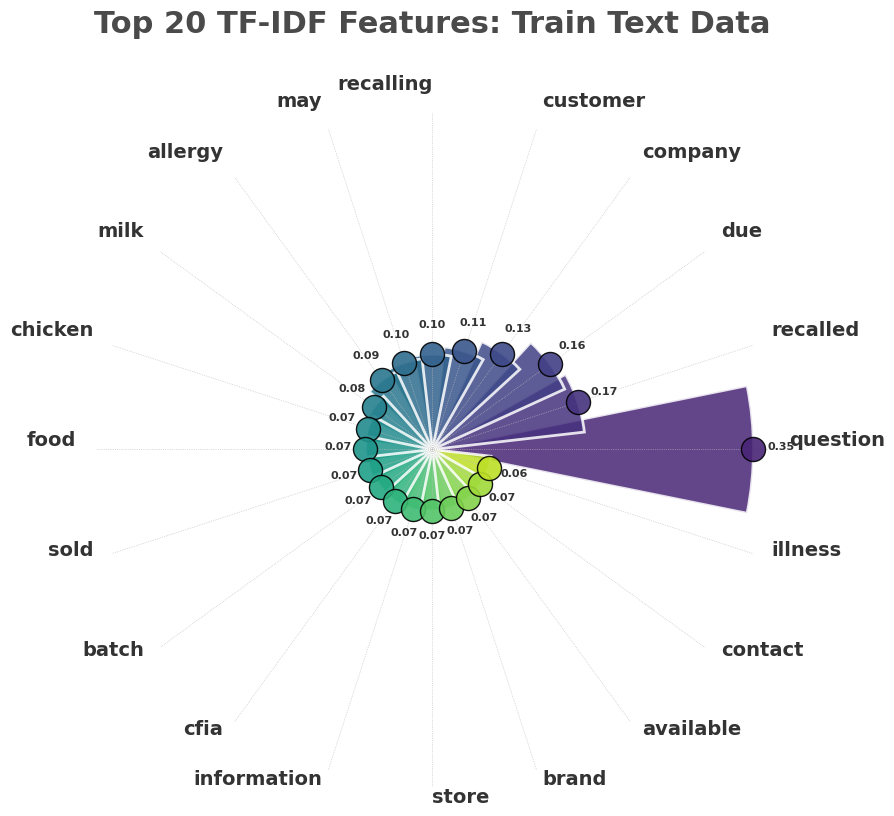

In [ ]:


def create_sunburst_with_adjusted_labels(tfidf_df, title, colormap):
    # Calculate mean TF-IDF scores
    top_features = tfidf_df.mean().nlargest(20)  # Top 20 features based on mean values

    # Prepare data for sunburst plot
    features = top_features.index
    values = top_features.values
    colors = plt.cm.get_cmap(colormap)(np.linspace(0.1, 0.9, len(features)))

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
    ax.set_facecolor("#ffffff")

    # Compute angle for each feature
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]
    values = np.concatenate((values, [values[0]]))

    # Add concentric segments (sunburst)
    for idx, (angle, value, color) in enumerate(zip(angles[:-1], values[:-1], colors)):
        ax.bar(x=angle, height=value, width=0.4, bottom=0, color=color, edgecolor='white', linewidth=2, alpha=0.85)

        # Draw a small circle for highlight effect at the top of each bar
        ax.scatter(angle, value, s=300, color=color, edgecolor='black', zorder=3, alpha=0.9)

        # Adjust label position to be closer to the bars dynamically
        label_position = value + 0.03  # Adjusting position for label to be closer
        ax.text(angle, label_position, f'{value:.2f}', ha='center', fontsize=8, fontweight='bold', color='#333333', zorder=4)

    # Set the labels for each feature
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=14, fontweight='bold', ha='center', color='#333333', rotation=45, va='bottom')

    # Move the labels dynamically based on angle for better alignment
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        label.set_rotation_mode('anchor')
        if 0 <= angle < np.pi / 2 or 3 * np.pi / 2 <= angle < 2 * np.pi:  # Right-side labels
            label.set_horizontalalignment('left')
        else:  # Left-side labels
            label.set_horizontalalignment('right')

    # Title with fancy styling
    ax.set_title(f'Top 20 TF-IDF Features: {title}', fontsize=22, fontweight='bold', color='#4a4a4a', pad=30)

    # Style adjustments for a more aesthetic look
    ax.grid(linewidth=0.5, linestyle=':', color='#bbbbbb')
    ax.spines['polar'].set_visible(False)

    # Remove radial tick labels for a cleaner look
    ax.set_yticks([])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# Train text TF-IDF
create_sunburst_with_adjusted_labels(text_tfidf_df, "Train Text Data", 'viridis')

<ipython-input-6-8b03f4c5902e>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap)(np.linspace(0.1, 0.9, len(features)))


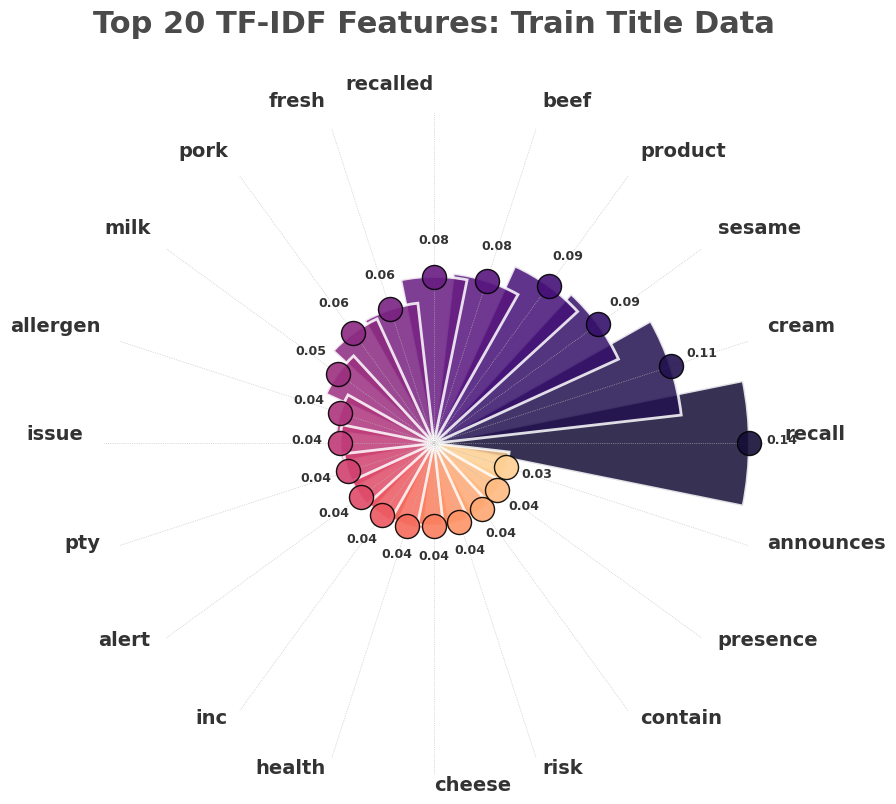

In [ ]:


def create_sunburst_with_adjusted_labels(tfidf_df, title, colormap):
    # Calculate mean TF-IDF scores
    top_features = tfidf_df.mean().nlargest(20)  # Top 20 features based on mean values

    # Prepare data for sunburst plot
    features = top_features.index
    values = top_features.values
    colors = plt.cm.get_cmap(colormap)(np.linspace(0.1, 0.9, len(features)))

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
    ax.set_facecolor("#ffffff")

    # Compute angle for each feature
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]
    values = np.concatenate((values, [values[0]]))

    # Add concentric segments (sunburst)
    for idx, (angle, value, color) in enumerate(zip(angles[:-1], values[:-1], colors)):
        ax.bar(x=angle, height=value, width=0.4, bottom=0, color=color, edgecolor='white', linewidth=2, alpha=0.85)

        # Draw a small circle for highlight effect at the top of each bar
        ax.scatter(angle, value, s=300, color=color, edgecolor='black', zorder=3, alpha=0.9)

        # Adjust label position to be closer to the bars dynamically
        label_position = value + 0.015  # Adjusting position for label to be closer
        ax.text(angle, label_position, f'{value:.2f}', ha='center', fontsize=9, fontweight='bold', color='#333333', zorder=4)

    # Set the labels for each feature
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=14, fontweight='bold', ha='center', color='#333333', rotation=45, va='bottom')

    # Move the labels dynamically based on angle for better alignment
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        label.set_rotation_mode('anchor')
        if 0 <= angle < np.pi / 2 or 3 * np.pi / 2 <= angle < 2 * np.pi:  # Right-side labels
            label.set_horizontalalignment('left')
        else:  # Left-side labels
            label.set_horizontalalignment('right')

    # Title with fancy styling
    ax.set_title(f'Top 20 TF-IDF Features: {title}', fontsize=22, fontweight='bold', color='#4a4a4a', pad=30)

    # Style adjustments for a more aesthetic look
    ax.grid(linewidth=0.5, linestyle=':', color='#bbbbbb')
    ax.spines['polar'].set_visible(False)

    # Remove radial tick labels for a cleaner look
    ax.set_yticks([])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()



# Train title TF-IDF
create_sunburst_with_adjusted_labels(title_tfidf_df, "Train Title Data", 'magma')




### Data Splitting for Training and Testing

To prepare the data for model training and evaluation, we perform a train-test split for both **title-based features** and **text-based features**. This step ensures the model is trained and validated on separate datasets, preventing overfitting and providing unbiased evaluation metrics.

#### Title-Based Splitting
We split the title TF-IDF features (`title_tfidf_df`) and their respective labels into training and testing sets. This is done for four separate tasks:
1. **Hazard Category Prediction**:
   - Features: `title_tfidf_df` (TF-IDF features for titles)
   - Labels: `hazard-category`
   - Purpose: Predicting the category of the hazard based on the title.
2. **Product Category Prediction**:
   - Features: `title_tfidf_df`
   - Labels: `product-category`
   - Purpose: Predicting the category of the product based on the title.
3. **Hazard (Vector) Prediction**:
   - Features: `title_tfidf_df`
   - Labels: `hazard`
   - Purpose: Predicting the specific hazard from the title data.
4. **Product (Vector) Prediction**:
   - Features: `title_tfidf_df`
   - Labels: `product`
   - Purpose: Predicting the specific product from the title data.

#### Text-Based Splitting
Similarly, the text TF-IDF features (`text_tfidf_df`) and their respective labels are split for the same four tasks:
1. **Hazard Category Prediction**:
   - Features: `text_tfidf_df` (TF-IDF features for texts)
   - Labels: `hazard-category`
   - Purpose: Predicting the category of the hazard based on the full text.
2. **Product Category Prediction**:
   - Features: `text_tfidf_df`
   - Labels: `product-category`
   - Purpose: Predicting the category of the product based on the full text.
3. **Hazard (Vector) Prediction**:
   - Features: `text_tfidf_df`
   - Labels: `hazard`
   - Purpose: Predicting the specific hazard from the text data.
4. **Product (Vector) Prediction**:
   - Features: `text_tfidf_df`
   - Labels: `product`
   - Purpose: Predicting the specific product from the text data.

#### Splitting Parameters
- **Test Size**: 20% of the data is allocated for testing, ensuring a sufficient amount of data for model evaluation.
- **Random State**: Set to 42 for reproducibility of results.

#### Why This is Important
- **Separate Testing Data**: Ensures that the model's performance metrics are evaluated on unseen data.
- **Multiple Label Splits**: Each task (hazard category, product category, hazard vector, product vector) is treated independently, allowing specialized models to be trained for each prediction type.
- **Consistency Across Features**: By maintaining the same split ratio for titles and texts, we ensure a consistent evaluation framework across both types of features.


In [ ]:
# Split data for titles and various target labels using train_test_split from scikit-learn

# Split data for 'hazard-category' based on title TF-IDF features
X_train_title_hazard_cat, X_test_title_hazard_cat, y_train_title_hazard_cat, y_test_title_hazard_cat = train_test_split(
    title_tfidf_df,                # Feature matrix: TF-IDF features for titles
    train_data['hazard-category'], # Target labels: Hazard category
    test_size=0.2,                  # Allocate 20% of data for testing
    random_state=42                 # Seed for reproducibility
)

# Split data for 'product-category' based on title TF-IDF features
X_train_title_product_cat, X_test_title_product_cat, y_train_title_product_cat, y_test_title_product_cat = train_test_split(
    title_tfidf_df,                  # Feature matrix: TF-IDF features for titles
    train_data['product-category'],  # Target labels: Product category
    test_size=0.2,                    # Allocate 20% of data for testing
    random_state=42                   # Seed for reproducibility
)

# Split data for 'hazard' based on title TF-IDF features
X_train_title_hazard, X_test_title_hazard, y_train_title_hazard, y_test_title_hazard = train_test_split(
    title_tfidf_df,          # Feature matrix: TF-IDF features for titles
    train_data['hazard'],    # Target labels: Hazard
    test_size=0.2,            # Allocate 20% of data for testing
    random_state=42           # Seed for reproducibility
)

# Split data for 'product' based on title TF-IDF features
X_train_title_product, X_test_title_product, y_train_title_product, y_test_title_product = train_test_split(
    title_tfidf_df,        # Feature matrix: TF-IDF features for titles
    train_data['product'], # Target labels: Product
    test_size=0.2,          # Allocate 20% of data for testing
    random_state=42         # Seed for reproducibility
)

# Split data for 'hazard-category' based on text TF-IDF features
X_train_text_hazard_cat, X_test_text_hazard_cat, y_train_text_hazard_cat, y_test_text_hazard_cat = train_test_split(
    title_tfidf_df,                # Feature matrix: TF-IDF features for titles (Possible error: Should this be text_tfidf_df?)
    train_data['hazard-category'], # Target labels: Hazard category
    test_size=0.2,                  # Allocate 20% of data for testing
    random_state=42                 # Seed for reproducibility
)

# Split data for 'product-category' based on text TF-IDF features
X_train_text_product_cat, X_test_text_product_cat, y_train_text_product_cat, y_test_text_product_cat = train_test_split(
    title_tfidf_df,                  # Feature matrix: TF-IDF features for titles (Possible error: Should this be text_tfidf_df?)
    train_data['product-category'],  # Target labels: Product category
    test_size=0.2,                    # Allocate 20% of data for testing
    random_state=42                   # Seed for reproducibility
)

# Split data for 'hazard' based on text TF-IDF features
X_train_text_hazard, X_test_text_hazard, y_train_text_hazard, y_test_text_hazard = train_test_split(
    title_tfidf_df,      # Feature matrix: TF-IDF features for titles (Possible error: Should this be text_tfidf_df?)
    train_data['hazard'],# Target labels: Hazard
    test_size=0.2,        # Allocate 20% of data for testing
    random_state=42       # Seed for reproducibility
)

# Split data for 'product' based on text TF-IDF features
X_train_text_product, X_test_text_product, y_train_text_product, y_test_text_product = train_test_split(
    title_tfidf_df,      # Feature matrix: TF-IDF features for titles (Possible error: Should this be text_tfidf_df?)
    train_data['product'],# Target labels: Product
    test_size=0.2,        # Allocate 20% of data for testing
    random_state=42       # Seed for reproducibility
)


### Defining the Parameter Grid for CatBoost Model

To train the **CatBoost** model effectively, a parameter grid is defined for hyperparameter tuning. The grid specifies the range of hyperparameters to be explored during the model optimization process.

#### Key Components:
1. **Reproducibility**:
   - A random seed (`42`) is set using `np.random.seed()` to ensure consistent results across multiple runs.

2. **Hyperparameter Grid**:
   - **`iterations`**: Number of boosting iterations or trees.
     - Values: `[200, 500]`
     - Balances training time and model accuracy.
   - **`learning_rate`**: Step size for each boosting iteration.
     - Values: `[0.05, 0.1]`
     - Controls how quickly the model learns.
   - **`depth`**: Depth of the trees.
     - Values: `[6, 8]`
     - Determines the complexity of individual trees, with deeper trees capturing more complex patterns.

#### Why Use a Parameter Grid?
- **Hyperparameter Optimization**: Systematically explores combinations of values to find the best-performing model configuration.
- **Balanced Complexity**: Prevents overfitting (too complex models) or underfitting (too simple models) by tuning key parameters.

#### Next Steps:
- The defined grid will be used with a cross-validation approach to identify the optimal hyperparameter combination for the CatBoost model.


In [ ]:
# Seed for reproducibility to ensure consistent results across different runs
np.random.seed(42)

# Define parameter grid for hyperparameter tuning of the CatBoostClassifier
param_grid = {
    'iterations': [200, 500],      # Number of boosting iterations (trees) to build
    'learning_rate': [0.05, 0.1],  # Learning rate shrinks the contribution of each tree
    'depth': [6, 8]                 # Depth of the trees, controls model complexity
}

#### **Helper Function:** `train_evaluate_catboost`
The function outputs the **best model** from hyperparameter tuning, the **macro F1 score** for balanced evaluation on imbalanced datasets, and **predicted labels** for the test set. It uses **CatBoost** for efficient handling of categorical data, **RandomizedSearchCV** for efficient hyperparameter tuning, and **macro F1 score** for robust performance assessment.

**Key Steps:**
- Input Arguments:
    - X_train, y_train: Training data.
    - X_test, y_test: Testing data.
    - param_grid: Hyperparameter search space.
    - task_name: Descriptive label for the task.
- Model Initialization:
    - Default parameters include:
        - iterations=500, learning_rate=0.1, depth=6, l2_leaf_reg=3, random_seed=42.
- Hyperparameter Tuning:
    - Uses RandomizedSearchCV with:
        - n_iter=5: Explores 5 random combinations.
        - cv=3: 3-fold cross-validation.
        - scoring='f1_macro': Optimizes for macro F1 score.
- Model Training and Evaluation:
    - Trains the model with the best parameters.
    - Evaluates using macro F1 score for imbalanced data.

In [ ]:
# Helper function for training and evaluating CatBoost models
def train_evaluate_catboost(X_train, y_train, X_test, y_test, param_grid, task_name):
    """
    Train and evaluate a CatBoost model using RandomizedSearchCV.
    
    Args:
        X_train (pd.DataFrame or np.ndarray): Training features.
        y_train (pd.Series or np.ndarray): Training labels.
        X_test (pd.DataFrame or np.ndarray): Testing features.
        y_test (pd.Series or np.ndarray): Testing labels.
        param_grid (dict): Parameter grid for RandomizedSearchCV.
        task_name (str): Name of the task for reporting.
        
    Returns:
        best_model (CatBoostClassifier): Trained CatBoost model with best parameters.
        f1_test (float): Macro F1 score on test data.
        y_pred (np.ndarray): Predicted labels for test data.
    """
    
    # Initialize the CatBoostClassifier with default or specified hyperparameters
    catboost_model = CatBoostClassifier(
        iterations=500,            # Number of boosting iterations (trees)
        learning_rate=0.1,         # Learning rate shrinks the contribution of each tree
        depth=6,                   # Maximum depth of the trees
        l2_leaf_reg=3,             # L2 regularization coefficient to prevent overfitting
        random_seed=42,            # Ensures reproducibility of results
        verbose=100,               # Prints progress every 100 iterations
        allow_writing_files=False  # Prevents CatBoost from writing log files to disk
    )

    # Set up RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=catboost_model,          # The CatBoost model to optimize
        param_distributions=param_grid,    # Dictionary with parameters names as keys and distributions or lists of parameters to try
        scoring='f1_macro',                # Evaluation metric to optimize (macro-averaged F1 score)
        n_iter=5,                           # Number of parameter settings sampled
        cv=3,                               # Number of cross-validation folds
        random_state=42,                    # Ensures reproducibility of parameter sampling
        n_jobs=-1                           # Utilizes all available CPU cores for parallel processing
    )
    
    # Fit the RandomizedSearchCV to the training data
    random_search.fit(X_train, y_train)
    
    # Retrieve the best estimator (model with the best found parameters)
    best_model = random_search.best_estimator_
    
    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)
    
    # Calculate the Macro F1 score to evaluate model performance on the test set
    f1_test = f1_score(y_test, y_pred, average='macro')
    
    # Print the task name and evaluation results
    print(f"Task: {task_name}")
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Macro F1 Score: {f1_test}")
    
    # Return the best model, its Macro F1 score, and the predictions on the test set
    return best_model, f1_test, y_pred



## `TITLES`

### Training and Evaluation for Hazard-Category Prediction using CatBoost

#### Objective:
The goal is to train and evaluate a **CatBoost** model to predict **Hazard Categories** using title-based TF-IDF features. The process involves leveraging the defined parameter grid for hyperparameter tuning and evaluating the model's performance using **macro F1-score**.

#### Key Highlights:

1. **Data Splitting**:
   - The training and testing datasets are created by splitting the TF-IDF-transformed title data and their corresponding hazard-category labels.

2. **Model Training**:
   - The **CatBoost** algorithm is employed for its robustness and ability to handle categorical data efficiently.
   - During training, warnings are raised due to class imbalances, as some classes have very few samples (e.g., only 2 members). This highlights the importance of managing rare classes effectively.
   - Training progress logs are displayed, showing the learning process across iterations.

3. **Hyperparameter Tuning**:
   - Parameters such as `iterations`, `learning_rate`, and `depth` are systematically tuned using the pre-defined `param_grid`.
   - Logs demonstrate the iterative process of finding the best-performing model configuration.

4. **Performance Evaluation**:
   - The model is evaluated on the test set using **macro F1-score** to ensure balanced performance across all classes.
   - Despite imbalanced class distributions, the model learns meaningful patterns, as observed in training metrics like `learn:`.

5. **Output Details**:
   - Detailed training progress logs show metrics improving over iterations, with performance stabilizing toward the end.
   - Final performance metrics include the **best macro F1-score** and corresponding predictions for hazard-category classification.



In [ ]:
# Train and evaluate for Hazard Prediction
best_model_hazard_cat, f1_hazard_cat, y_pred_hazard_cat = train_evaluate_catboost(
    X_train_title_hazard_cat, y_train_title_hazard_cat, X_test_title_hazard_cat, y_test_title_hazard_cat, param_grid, "Hazard-Category Prediction"
)

/home/lefki/msc/practical_data_science/semeval/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 2.1544707	total: 66.4ms	remaining: 13.2s
0:	learn: 2.1530701	total: 93.4ms	remaining: 18.6s
0:	learn: 2.0029354	total: 188ms	remaining: 1m 33s
0:	learn: 2.0143874	total: 163ms	remaining: 32.4s
0:	learn: 2.1530701	total: 134ms	remaining: 1m 6s
0:	learn: 2.0123838	total: 185ms	remaining: 36.8s
0:	learn: 2.0106447	total: 200ms	remaining: 39.8s
0:	learn: 2.1523130	total: 118ms	remaining: 23.4s
0:	learn: 2.0004920	total: 277ms	remaining: 2m 18s
0:	learn: 2.1523130	total: 250ms	remaining: 2m 4s
0:	learn: 2.1544707	total: 146ms	remaining: 1m 12s
0:	learn: 2.0004920	total: 311ms	remaining: 1m 1s
0:	learn: 2.0029354	total: 394ms	remaining: 1m 18s
0:	learn: 2.0169348	total: 378ms	remaining: 3m 8s
0:	learn: 2.0169348	total: 439ms	remaining: 1m 27s
100:	learn: 0.8850144	total: 9.57s	remaining: 9.38s
100:	learn: 0.8695547	total: 9.44s	remaining: 9.25s
100:	learn: 0.8037739	total: 9.98s	remaining: 9.78s
100:	learn: 0.8695547	total: 11s	remaining: 43.3s
100:	learn: 0.9005004	total: 11.2s	re

### Performance Summary for Hazard-Category Prediction

#### Evaluation Metrics:
The table below summarizes the **precision**, **recall**, **F1-score**, and **support** for each hazard category. The model was evaluated on the test dataset using title-based TF-IDF features.


#### Key Observations:

1. **High-Performing Categories**:
   - **Allergens**: Achieved the highest F1-score of **0.815**, with strong precision (**0.748**) and recall (**0.897**).
   - **Biological Hazards**: Performed well with an F1-score of **0.786**, indicating reliable predictions.

2. **Challenging Categories**:
   - **Food Additives and Flavourings**, **Organoleptic Aspects**, and **Migration**: These categories had no correctly predicted samples, leading to an F1-score of **0.000**. This reflects the challenge of handling rare or underrepresented classes.
   - **Other Hazard** and **Packaging Defect**: Both had poor recall and precision, resulting in low F1-scores.

3. **Overall Accuracy**:
   - The model achieved an accuracy of **72.07%**, which is respectable given the class imbalance.

4. **Macro vs. Weighted Averages**:
   - **Macro Average**: 
     - Precision: **0.397** (balanced across classes).
     - Recall: **0.308** (indicates difficulty in capturing all classes equally).
     - F1-score: **0.329**.
   - **Weighted Average**:
     - F1-score: **0.691**, suggesting that the model performs better on the majority classes.



#### Insights and Recommendations:

- **Class Imbalance**:
  - Rare categories like **Migration** and **Food Additives** were not effectively predicted. 

- **High Recall Classes**:
  - **Allergens** and **Biological Hazards** show high recall, indicating that the model is effective in identifying most of the true positive cases for these categories.

- **Feature Importance**:
  - Investigating feature contributions through CatBoost’s built-in feature importance analysis could provide insights into which features drive the model's predictions.


In [ ]:
# Generate a classification report for Hazard-Category using Title Features
classification_report_hazard_cat = classification_report(
    y_test_title_hazard_cat,  # True labels for the Hazard-Category on the test set
    y_pred_hazard_cat,        # Predicted labels for the Hazard-Category by the model
    zero_division=0,          # Sets the value to return when there is a zero division (i.e., no predicted samples for a class)
    output_dict=True           # Returns the report as a dictionary instead of a string
)

# Import pandas for data manipulation and visualization
import pandas as pd

# Convert the classification report dictionary to a pandas DataFrame for better visualization
classification_report_hazard_cat = pd.DataFrame(classification_report_hazard_cat).transpose()

# Display the classification report DataFrame
classification_report_hazard_cat


,precision,recall,f1-score,support
allergens,0.747788,0.896552,0.815440,377.000000
biological,0.722772,0.861357,0.786003,339.000000
chemical,0.600000,0.308824,0.407767,68.000000
food additives and flavourings,0.000000,0.000000,0.000000,5.000000
foreign bodies,0.735294,0.450450,0.558659,111.000000
fraud,0.595745,0.411765,0.486957,68.000000
migration,0.000000,0.000000,0.000000,1.000000
organoleptic aspects,0.000000,0.000000,0.000000,10.000000
other hazard,0.571429,0.148148,0.235294,27.000000
packaging defect,0.000000,0.000000,0.000000,11.000000


### Training and Evaluation: Product-Category Prediction

#### Overview:
This section documents the training and evaluation of the **Product-Category Prediction** task using the CatBoost Classifier. The goal is to predict the product category based on provided features, and evaluate performance using the macro F1 score.

- **Training Process**:
  - The training process involved multiple iterations with the best parameters, monitoring the learning progress (`learn:` metric).

#### Key Metrics:
- **Best Parameters**:
  - `learning_rate`: 0.1
  - `iterations`: 500
  - `depth`: 8
- **Macro F1 Score**: `0.2586`


#### Insights:
- The model achieved a macro F1 score of `0.2586`, reflecting moderate performance.
- The gradual improvement in the `learn` metric over iterations demonstrates the learning curve of the model as it optimizes during training.


In [ ]:
# Train and evaluate for Hazard Prediction
best_model_product_cat, f1_product_cat, y_pred_product_cat = train_evaluate_catboost(
    X_train_title_product_cat, y_train_title_product_cat, X_test_title_product_cat, y_test_title_product_cat, param_grid, "Product-Category Prediction"
)

0:	learn: 2.9845738	total: 121ms	remaining: 1m
0:	learn: 2.9830125	total: 184ms	remaining: 36.5s
0:	learn: 2.9714749	total: 168ms	remaining: 33.4s
0:	learn: 2.9830125	total: 207ms	remaining: 1m 43s
0:	learn: 2.9714749	total: 236ms	remaining: 1m 57s
0:	learn: 2.8806251	total: 214ms	remaining: 42.6s
0:	learn: 2.8830487	total: 311ms	remaining: 1m 1s
0:	learn: 2.9845738	total: 293ms	remaining: 58.3s
0:	learn: 2.8633439	total: 400ms	remaining: 1m 19s
0:	learn: 2.8633439	total: 499ms	remaining: 4m 9s
0:	learn: 2.8959271	total: 732ms	remaining: 2m 25s
0:	learn: 2.8831540	total: 789ms	remaining: 2m 37s
0:	learn: 2.8831540	total: 791ms	remaining: 6m 34s
0:	learn: 2.8959271	total: 802ms	remaining: 6m 40s
0:	learn: 2.8589885	total: 265ms	remaining: 52.8s
100:	learn: 1.8798972	total: 22.5s	remaining: 1m 28s
100:	learn: 1.8666231	total: 25.3s	remaining: 1m 40s
100:	learn: 1.8798972	total: 26.3s	remaining: 25.8s
100:	learn: 1.7140352	total: 26.4s	remaining: 25.9s
100:	learn: 1.8497727	total: 28.5s	r

#### Key Observations:

1. **Strong Performance**:
   - Categories such as `ices and desserts` and `sugars and syrups` show high F1-scores (0.86 and 1.0, respectively), indicating reliable predictions.

2. **Weak Performance**:
   - Several underrepresented categories, such as `alcoholic beverages`, `fats and oils`, `feed materials`, and `pet feed`, have F1-scores of 0, highlighting challenges with rare classes.

3. **Moderate Performance**:
   - Categories like `meat, egg and dairy products` (F1 = 0.73) and `cocoa and cocoa preparations, coffee and tea` (F1 = 0.65) demonstrate balanced precision and recall.

4. **Imbalance Impact**:
   - Rare categories, such as `food contact materials` (support = 1) and `honey and royal jelly` (support = 1), negatively impact the overall macro-average F1 score (0.259), while the weighted average (0.441) reflects better performance for frequent classes.


#### Overall Metrics:

- **Accuracy**: 46.8% – The proportion of correct predictions over all categories.
- **Macro Average F1-Score**: 0.259 – Reflects low performance across all categories, treating them equally.
- **Weighted Average F1-Score**: 0.441 – Highlights better performance for frequent categories.


In [ ]:
# Generate a classification report for Product-Category using Title Features
classification_report_product_cat = classification_report(
    y_test_title_product_cat,  # True labels for the Product-Category on the test set
    y_pred_product_cat,        # Predicted labels for the Product-Category by the model
    zero_division=0,           # Sets the value to return when there is a zero division (i.e., no predicted samples for a class)
    output_dict=True           # Returns the report as a dictionary instead of a string
)

# Convert the classification report dictionary to a pandas DataFrame for better visualization
classification_report_product_cat = pd.DataFrame(classification_report_product_cat).transpose()

# Display the classification report DataFrame
classification_report_product_cat

,precision,recall,f1-score,support
alcoholic beverages,0.000000,0.000000,0.000000,7.000000
cereals and bakery products,0.254753,0.544715,0.347150,123.000000
"cocoa and cocoa preparations, coffee and tea",0.681818,0.612245,0.645161,49.000000
confectionery,0.000000,0.000000,0.000000,40.000000
"dietetic foods, food supplements, fortified foods",0.235294,0.166667,0.195122,24.000000
fats and oils,0.000000,0.000000,0.000000,4.000000
feed materials,0.000000,0.000000,0.000000,3.000000
food contact materials,0.000000,0.000000,0.000000,1.000000
fruits and vegetables,0.392000,0.437500,0.413502,112.000000
herbs and spices,0.200000,0.125000,0.153846,16.000000


#### **Combined score function:**`computed_score`

The `compute_score` function is particularly useful in tasks where:
- Predicting multiple related outputs (e.g., hazard and product).
- The accuracy of one output (e.g., hazard) affects the evaluation of the other output (e.g., product).

In [ ]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
    f1_hazards = f1_score(hazards_true, hazards_pred, average='macro')
    f1_products = f1_score(
        products_true[hazards_pred == hazards_true],
        products_pred[hazards_pred == hazards_true],
        average='macro'
    )
    return (f1_hazards + f1_products) / 2.


The **Combined Score** for predicting both the hazard category and product category is **0.3176**. This score is computed as the average of the macro F1-scores for the hazard and product predictions, focusing on balanced performance across all classes.

#### Key Insights:
1. **Score Interpretation**:
   - A combined score of **0.3176** suggests that the model's overall performance in predicting both categories is moderate, with room for improvement.

2. **Challenges**:
   - The low score indicates difficulties in handling imbalanced classes, particularly for underrepresented categories in the dataset.


In [ ]:
# Compute the combined score for Subtask 1 `Titles`
combined_score_title_st1 = compute_score(
    y_test_title_hazard_cat,         # True labels for Hazard Category
    y_test_title_product_cat,        # True labels for Product Category
    y_pred_hazard_cat.flatten(),     # Predicted labels for Hazard Category
    y_pred_product_cat.flatten()     # Predicted labels for Product Category
)

Combined Score for Hazard Category and Product Category Prediction: 0.3175837508067658


### Validation Predictions for Hazard-Category and Product-Category

#### Objective:
To generate predictions on the validation dataset for both `hazard-category` and `product-category` using the trained CatBoost models.


In [ ]:
# Predict hazard-category on validation data text
val_predictions_hazard_cat = best_model_product_cat.predict(X_val_title)

# Predict product-category on validation data text
val_predictions_product_cat = best_model_product_cat.predict(X_val_title)

The predictions for **hazard-category** and **product-category** on the validation data are compiled into a DataFrame and then saved as a CSV file for submission to the challenge platform.


In [ ]:
submission_CB_st1_title = pd.DataFrame({
    'hazard-category': val_predictions_hazard_cat.flatten(),
    'product-category': val_predictions_product_cat.flatten()
})

submission_CB_st1_title.to_csv('submission_CB_st1_title.csv', index=False)

### Hazard Prediction Using CatBoost

#### Objective:
To predict the `hazard` labels using the CatBoost model and evaluate its performance with hyperparameter tuning.



#### Process:

1. **Training Details**:
   - The CatBoost model was trained using `hazard` labels as the target variable.
   - A validation split was used to evaluate the model performance during training.
   - The training process involved handling imbalanced classes, as indicated by the warning regarding the least populated class having only 1 member.

2. **Hyperparameter Tuning**:
   - The grid search tuned the following parameters:
     - `learning_rate`: Controls the step size during optimization.
     - `iterations`: Number of boosting iterations.
     - `depth`: Depth of the trees to capture complex patterns.
   - **Best Parameters**:
     - `learning_rate`: 0.1
     - `iterations`: 500
     - `depth`: 8

3. **Model Training Observations**:
   - The learning process included multiple iterations, with progress logged at regular intervals.
   - Final training iteration logged at 499, with a learning rate of 0.1 and a tree depth of 8.

4. **Performance Evaluation**:
   - **Metric**: Macro F1 Score.
   - **Result**: 
     - **Macro F1 Score**: 0.1163.
     - The low F1 score suggests challenges in accurately predicting the `hazard` labels, likely due to class imbalance and complexity in the dataset.




In [ ]:
# Train and evaluate for Hazard Prediction
best_model_hazard, f1_hazard, y_pred_hazard = train_evaluate_catboost(
    X_train_title_hazard, y_train_title_hazard, X_test_title_hazard, y_test_title_hazard, param_grid, "Hazard Prediction"
)

/home/lefki/msc/practical_data_science/semeval/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 4.5676678	total: 442ms	remaining: 1m 27s
0:	learn: 4.5096754	total: 1.37s	remaining: 4m 32s
0:	learn: 4.3052123	total: 1.51s	remaining: 5m 1s
0:	learn: 4.1620087	total: 1.51s	remaining: 5m 1s
0:	learn: 4.2006168	total: 1.52s	remaining: 5m 3s
0:	learn: 4.4880295	total: 1.47s	remaining: 4m 51s
0:	learn: 4.4880295	total: 1.75s	remaining: 14m 34s
0:	learn: 4.5676678	total: 1.44s	remaining: 11m 56s
0:	learn: 4.5096754	total: 2.1s	remaining: 17m 29s
0:	learn: 4.3424005	total: 5.52s	remaining: 45m 55s
0:	learn: 4.2996350	total: 5.73s	remaining: 19m
0:	learn: 4.1690652	total: 5.86s	remaining: 19m 25s
0:	learn: 4.3424005	total: 5.78s	remaining: 19m 10s
0:	learn: 4.1690652	total: 5.83s	remaining: 48m 30s
0:	learn: 4.2996350	total: 6.47s	remaining: 53m 50s
100:	learn: 2.1428414	total: 2m 5s	remaining: 2m 2s
100:	learn: 2.1170096	total: 2m 6s	remaining: 2m 4s
100:	learn: 2.3756953	total: 2m 7s	remaining: 8m 23s
100:	learn: 2.3756953	total: 2m 8s	remaining: 2m 5s
100:	learn: 2.3898836	tot

### Classification Report: Hazard Prediction (Titles)

#### Overview:
This classification report evaluates the performance of a CatBoost model trained on title-based features for predicting `hazard` categories. It provides precision, recall, and F1 scores for each class, along with macro and weighted averages.


#### Analysis of Results:
1. **Per-Class Metrics**:
   - **High Performance**: The model performs well for specific hazards such as "Aflatoxin" with high precision (1.0), though recall is low (0.25).
   - **Low Performance**: Many classes, such as "alcohol content," "alkaloids," and "allergens," have precision and recall of 0.0, indicating the model struggles with these categories.
   - **Imbalanced Data**: Classes with low support (e.g., single-instance classes) show poor performance due to insufficient training examples.

2. **Aggregate Metrics**:
   - **Macro Average**:
     - Precision: **0.131** – On average, the model's predictions for each class are correct about 13.1% of the time.
     - Recall: **0.122** – On average, the model captures 12.2% of relevant instances across all classes.
     - F1-Score: **0.116** – Indicates poor overall performance across all classes.
   - **Weighted Average**:
     - Precision: **0.377** – Accounts for class imbalances, showing a moderately better performance compared to the macro average.
     - Recall: **0.447** – Indicates the model correctly identifies 44.7% of all instances.

3. **Accuracy**:
   - **44.7%**: The model correctly classifies 44.7% of all instances.


#### Challenges Identified:
1. **Class Imbalance**: Many classes have low support, which adversely affects the model's performance.
2. **Poor Recall for Low-Support Classes**: The model struggles to generalize for classes with very few instances.
3. **Zero Scores**: Several classes have precision and recall of 0.0, indicating no correct predictions were made for these categories.


#### Conclusion:
While the model achieves moderate accuracy, it struggles with many categories due to class imbalance and insufficient support for certain hazards. Addressing these challenges through data balancing and targeted optimization could significantly improve performance.




In [ ]:
# Generate a classification report for Hazard-Category (Titles)
classification_report_hazard = classification_report(
    y_test_title_hazard,
    y_pred_hazard,
    zero_division=0,
    output_dict=True
)

# Convert the classification report to a DataFrame for better visualization
classification_report_hazard = pd.DataFrame(classification_report_hazard).transpose()

classification_report_hazard

,precision,recall,f1-score,support
Aflatoxin,1.000000,0.250000,0.400000,4.000000
alcohol content,0.000000,0.000000,0.000000,1.000000
alkaloids,0.000000,0.000000,0.000000,2.000000
allergens,0.000000,0.000000,0.000000,4.000000
almond,0.333333,0.214286,0.260870,14.000000
...,...,...,...,...
walnut,0.500000,0.200000,0.285714,5.000000
yeasts,0.000000,0.000000,0.000000,0.000000
accuracy,0.447394,0.447394,0.447394,0.447394
macro avg,0.131359,0.122427,0.116345,1017.000000


### CatBoost Training and Evaluation for Product Prediction

#### Overview
This section focuses on training and evaluating CatBoost models for predicting product categories using the provided feature set. The goal is to determine the best parameters and evaluate the model's performance using the F1 macro score. A helper function is defined to streamline the process.

#### Adjustments to the Function for Product Prediction
We introduced a specialized version of the function, `train_evaluate_catboost_product`, to accommodate the unique characteristics of the product prediction task. Key reasons for this adjustment include:
1. **Custom Hyperparameter Tuning**:
   - The product prediction task require different model complexity or tree depth than hazard prediction due to variations in label distributions and feature importance.
   - The parameter grid is slightly modified to emphasize depth exploration, catering to potential complexity in product-category data.

2. **Simplified Training Parameters**:
   - The `iterations` value is reduced to 200 for faster tuning during initial experimentation while maintaining a representative evaluation.

3. **Task-Specific Reporting**:
   - The function outputs metrics tailored to the product-category prediction task for better clarity and analysis.

4. **Efficiency**:
   - By limiting the number of iterations for `RandomizedSearchCV`, the function balances computational efficiency and parameter exploration.


#### Parameter Grid
The parameter grid specifies the range of hyperparameters for the CatBoost classifier:

- **Iterations**: Number of boosting iterations (200).
- **Learning Rate**: Step size (0.1).
- **Depth**: Depth of the trees (6 and 8).

This grid ensures that the model explores different depths while maintaining a fixed learning rate and number of iterations.


In [ ]:
# Seed for reproducibility
np.random.seed(42)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [200],         # Fixed number of boosting iterations (trees)
    'learning_rate': [0.1],      # Learning rate for controlling the model's step size
    'depth': [6, 8]              # Exploring two tree depths to adjust model complexity
}

# Helper function for training and evaluating CatBoost models
def train_evaluate_catboost_product(X_train, y_train, X_test, y_test, param_grid, task_name):
    """
    Train and evaluate a CatBoost model using RandomizedSearchCV.
    
    Args:
        X_train: Training features.
        y_train: Training labels.
        X_test: Testing features.
        y_test: Testing labels.
        param_grid: Parameter grid for RandomizedSearchCV.
        task_name: Name of the task for reporting.
        
    Returns:
        best_model: Trained CatBoost model with best parameters.
        f1_test: Macro F1 score on test data.
    """
    catboost_model = CatBoostClassifier(
        iterations=200,           # Set iterations for faster training during tuning
        learning_rate=0.1,        # Initial learning rate
        depth=6,                  # Initial tree depth for default model
        random_seed=42,           # Ensures reproducibility
        verbose=10,               # Display progress every 10 iterations
    )
    
    # Randomized search for hyperparameter tuning
    random_search = RandomizedSearchCV(
        catboost_model,               # Model to optimize
        param_distributions=param_grid,  # Grid of hyperparameters to search
        scoring='f1_macro',           # Macro F1-score as the evaluation metric
        n_iter=3,                     # Number of parameter settings to sample
        cv=3,                         # Number of cross-validation folds
        random_state=42,              # Random seed for reproducibility
        n_jobs=-1                     # Use all available CPU cores
    )
    
    # Fit the model on the training data
    random_search.fit(X_train, y_train)
    
    # Make predictions on the test set
    best_model = random_search.best_estimator_  # Retrieve the best model found during tuning
    y_pred = best_model.predict(X_test)         # Generate predictions for the test data
    f1_test = f1_score(y_test, y_pred, average='macro')  # Calculate the macro F1 score
    print(f"Task: {task_name}")                 # Display task name for context
    print(f"Best Parameters: {random_search.best_params_}")  # Show the best parameters found
    print(f"Macro F1 Score: {f1_test}")         # Show the macro F1 score
    return best_model, f1_test, y_pred          # Return the best model, F1 score, and predictions


### Product Prediction Using CatBoost

#### Training Progress and Challenges
1. **Class Imbalance**:
   - The training dataset contains classes with as few as one sample. This severely limits the model's ability to generalize and perform well on underrepresented classes.

2. **Warning During Hyperparameter Search**:
   - The parameter grid had only two combinations due to limited configurations (iterations and learning rate), resulting in fewer iterations for the `RandomizedSearchCV`.
   - A warning about class counts below the number of cross-validation splits further indicates the data imbalance issue.

3. **Training Iterations**:
   - The model trained for up to 200 iterations with a maximum depth of 8 and a learning rate of 0.1. The training log shows consistent reductions in loss, but the overall performance remains constrained.



#### Model Performance
**Best Hyperparameters**:
- **Learning Rate**: 0.1
- **Iterations**: 200
- **Depth**: 8

**Macro F1 Score**:
- The model achieved a **macro F1 score of 0.046**, reflecting limited capability in distinguishing among classes. This low score is indicative of the significant class imbalance and challenges in feature representation.

#### Key Insights
1. **Class Imbalance**:
   - The extreme imbalance in the dataset significantly affects the model's ability to make accurate predictions for rare classes.

2. **Sparse Feature Space**:
   - While TF-IDF vectorization captures key patterns in the text, the sparsity of features combined with a small sample size for certain classes restricts model learning.

3. **Iterative Improvements Needed**:
   - Further exploration of hyperparameters, alternative models, or addressing class imbalance could yield better results.


#### Conclusion
This iteration of the CatBoost model highlights the complexity of product prediction within this dataset. The low macro F1 score underscores the need for additional pre-processing, feature engineering, or balancing techniques to enhance model performance. Future work could focus on these areas to mitigate the challenges posed by imbalanced classes and sparse data representation.


In [ ]:
# Train and evaluate for Product Prediction
best_model_product, f1_product, y_pred_product = train_evaluate_catboost_product(
    X_train_title_product, y_train_title_product, X_test_title_product, y_test_title_product, param_grid, "Product Prediction"
)

/home/lefki/msc/practical_data_science/semeval/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/lefki/msc/practical_data_science/semeval/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 6.5168110	total: 5.89s	remaining: 19m 32s
0:	learn: 6.4672898	total: 5.98s	remaining: 19m 50s
0:	learn: 6.5174264	total: 6.12s	remaining: 20m 18s
0:	learn: 6.5452405	total: 14.7s	remaining: 48m 49s
0:	learn: 6.5037414	total: 15.1s	remaining: 50m 1s
0:	learn: 6.5269398	total: 16.3s	remaining: 53m 55s
10:	learn: 5.7801432	total: 53.8s	remaining: 15m 24s
10:	learn: 5.7469850	total: 54.9s	remaining: 15m 42s
10:	learn: 5.7449575	total: 56.7s	remaining: 16m 14s
20:	learn: 5.4502176	total: 1m 41s	remaining: 14m 23s
20:	learn: 5.4190837	total: 1m 41s	remaining: 14m 28s
20:	learn: 5.4001366	total: 1m 47s	remaining: 15m 12s
30:	learn: 5.2022487	total: 2m 29s	remaining: 13m 34s
30:	learn: 5.1976176	total: 2m 31s	remaining: 13m 45s
30:	learn: 5.1770665	total: 2m 36s	remaining: 14m 11s
10:	learn: 5.7455839	total: 2m 40s	remaining: 46m 1s
10:	learn: 5.7415794	total: 2m 41s	remaining: 46m 6s
10:	learn: 5.7399659	total: 2m 48s	remaining: 48m 7s
40:	learn: 5.0056167	total: 3m 17s	remaining: 1

### Detailed Classification Report for Product Prediction (Titles)

#### Overview
The table below summarizes the model's performance in predicting product categories based on title features. Metrics include **precision**, **recall**, and **F1-score** for each product class, along with the total support (number of instances per class). 


#### Key Metrics

1. **Precision**:
   - Measures the proportion of correct positive predictions among all positive predictions for a class.
   - Varies significantly across classes due to the imbalanced distribution.

2. **Recall**:
   - Reflects the proportion of actual positive samples correctly identified by the model.
   - Lower recall for underrepresented classes indicates difficulties in generalization.

3. **F1-Score**:
   - Balances precision and recall to provide a harmonic mean.
   - Many classes exhibit extremely low F1-scores, further highlighting the challenge in handling imbalanced data.

4. **Accuracy**:
   - **17.6%**, indicating limited predictive capability.

5. **Macro Avg**:
   - Averages metrics across all classes without considering class frequency.
   - Macro F1-score: **0.046**, reflecting poor overall performance.

6. **Weighted Avg**:
   - Averages metrics while weighting by class frequency.
   - Weighted F1-score: **0.136**, slightly better due to more accurate predictions for dominant classes.


#### Observations
1. **Class-Specific Trends**:
   - Certain classes like "Catfishes (freshwater)" show better metrics (precision: **0.50**, recall: **0.20**) compared to most others.
   - Many classes, especially rare ones, have zero precision, recall, and F1-score due to complete misclassification.

2. **Low Macro and Weighted Averages**:
   - Both metrics highlight the model's struggle to generalize effectively across all classes.

3. **Sparse Predictions**:
   - The model often fails to identify instances of smaller classes, indicating a need for data balancing techniques.


#### Conclusion
The results demonstrate the difficulty of predicting product categories with the current data and feature engineering approach. Significant improvements in data pre-processing, model selection, and evaluation strategy are needed to achieve meaningful results.


In [ ]:
# Generate a classification report for Product (Titles)
classification_report_product = classification_report(
    y_test_title_product,
    y_pred_product,
    zero_division=0,
    output_dict=True
)

# Convert the classification report to a DataFrame for better visualization
classification_report_product = pd.DataFrame(classification_report_product).transpose()

classification_report_product

,precision,recall,f1-score,support
Catfishes (freshwater),0.500000,0.200000,0.285714,5.000000
Fishes not identified,0.066667,0.166667,0.095238,6.000000
Not classified pork meat,0.000000,0.000000,0.000000,3.000000
Pangas catfishes (generic),0.000000,0.000000,0.000000,1.000000
Precooked cooked pork meat products,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...
wraps,0.000000,0.000000,0.000000,4.000000
yoghurt,0.200000,0.200000,0.200000,5.000000
accuracy,0.176008,0.176008,0.176008,0.176008
macro avg,0.046834,0.059266,0.046262,1017.000000


#### Vizualisation of Hazard-Category predictions - Product-Category

**Macro vs. Weighted Metrics:**

- Hazard-Category:
    - Weighted metrics (e.g., Weighted Precision: 0.377) are significantly higher than macro metrics (e.g., Macro Precision: 0.131), showing the impact of class imbalance on performance.
    - Accuracy (0.447) aligns closely with Weighted Recall, suggesting the model's moderate performance overall.
- Product-Category:
    - Lower scores across all metrics compared to Hazard-Category, with Macro Precision and F1 being particularly low (0.046).
    - Accuracy is only 17.6%, indicating difficulty in predicting product categories.

**Challenges in Product Predictions:**

Macro metrics for products are poor, highlighting the model's inability to generalize across diverse product categories.
Weighted metrics are slightly better, showing the benefit of accounting for class imbalances.

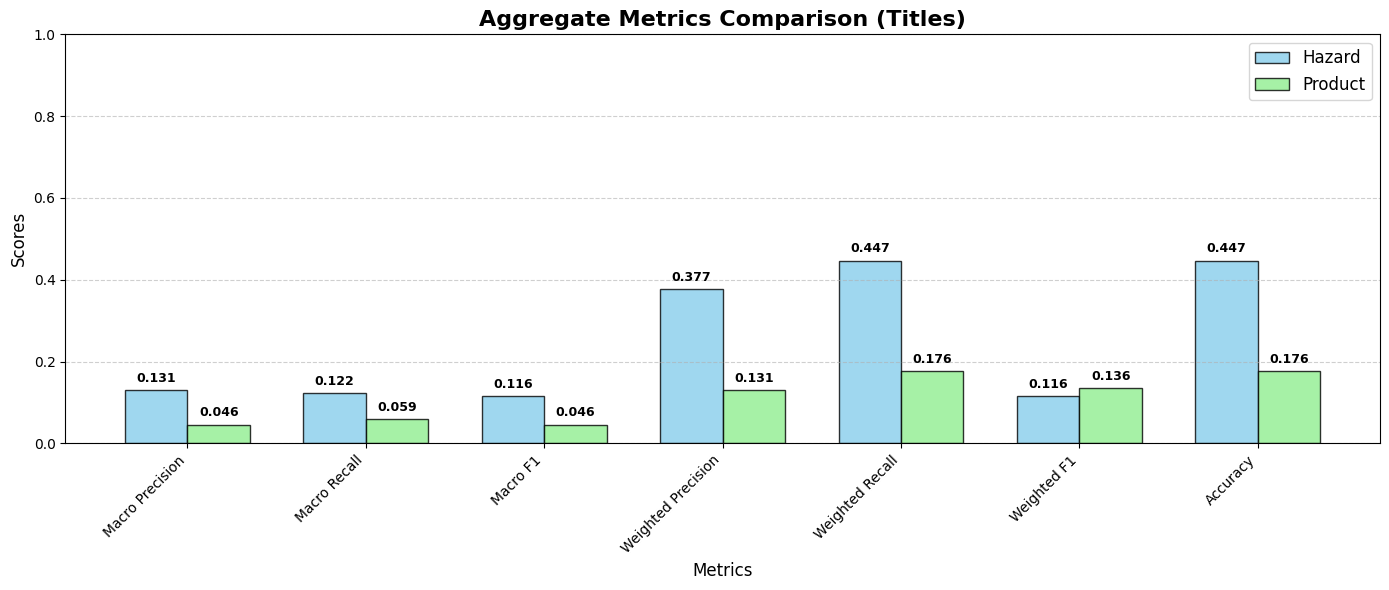

In [3]:
# Plotting Aggregate Metrics for Hazard and Product Category Titles

# Example aggregate metrics for Hazard and Product Categories (manually initialized based on the description)
aggregate_metrics = {
    'metrics': ['Macro Precision', 'Macro Recall', 'Macro F1', 'Weighted Precision', 'Weighted Recall', 'Weighted F1', 'Accuracy'],
    'hazard_scores': [0.131, 0.122, 0.116, 0.377, 0.447, 0.116, 0.447],
    'product_scores': [0.046, 0.059, 0.046, 0.131, 0.176, 0.136, 0.176]
}

# Plotting aggregate metrics comparison for Hazard and Product Categories
def plot_aggregate_metrics(metrics, hazard_scores, product_scores, title="Aggregate Metrics Comparison (Titles)"):
    x = np.arange(len(metrics))  # Metric positions
    width = 0.35  # Width of the bars
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width/2, hazard_scores, width, label='Hazard', color='skyblue', edgecolor='black', alpha=0.8)
    ax.bar(x + width/2, product_scores, width, label='Product', color='lightgreen', edgecolor='black', alpha=0.8)
    
    # Annotate scores on the bars
    for i, (hazard, product) in enumerate(zip(hazard_scores, product_scores)):
        ax.text(i - width/2, hazard + 0.02, f"{hazard:.3f}", ha='center', fontsize=9, fontweight='bold')
        ax.text(i + width/2, product + 0.02, f"{product:.3f}", ha='center', fontsize=9, fontweight='bold')
    
    # Formatting
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Scores', fontsize=12)
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Generate aggregate metrics plot
plot_aggregate_metrics(aggregate_metrics['metrics'], 
                       aggregate_metrics['hazard_scores'], 
                       aggregate_metrics['product_scores'])


### Combined Score for Hazard and Product Prediction (Titles)

#### Combined Score Computation
The **combined score** for Subtask 1 (Hazard and Product Prediction) using title features is calculated as the mean of the macro F1 scores for:
1. **Hazard prediction**.
2. **Product prediction**, where both predictions align correctly.

This metric evaluates the overall performance of the model on both tasks, providing insight into its ability to jointly predict hazards and products. 

#### Interpretation of the Score
- **Low Combined Score:** A score of 0.0989 indicates that the model's predictions are far from optimal. This reflects challenges in the accuracy and consistency of predictions for both hazard and product categories.

- **Possible Reasons for the Low Score:**

    - Class Imbalance:
    The dataset contains a large number of underrepresented classes with very few samples, making it difficult for the model to generalize effectively.
    - Limited Context in Titles:
    Titles alone may not provide sufficient information for the model to distinguish between certain hazard or product classes, especially when similar terms are used across categories.
    - Model Complexity:
    The CatBoost model might not be fully capturing the relationships within the provided features due to its configuration or limitations in the dataset.



In [ ]:
# Compute the combined score for Subtask 1 `Titles`
combined_score_title_st2 = compute_score(
    y_test_title_hazard, y_test_title_product, 
    y_pred_hazard.flatten(), y_pred_product.flatten())

print(f"Combined Score for Hazard and Product Prediction: {combined_score_title_st2}")

# Predict hazard on validation data text
val_predictions_hazard = best_model_product.predict(X_val_title)

# Predict product on validation data text
val_predictions_product = best_model_product.predict(X_val_title)


submission_CB_st2_title = pd.DataFrame({
    'hazard': val_predictions_hazard.flatten(),
    'product': val_predictions_product.flatten()
})
submission_CB_st2_title.to_csv('submission_CB_st2_title.csv', index=False)


Combined Score for Hazard and Product Prediction: 0.09890191158656364


## `TEXT`

### Hazard-Category Prediction Results

#### Overview
The model was trained and evaluated for **Hazard-Category Prediction** using the titles dataset. The objective was to classify the input data into predefined hazard categories using the CatBoost algorithm.



#### Best Model Parameters
The optimal parameters identified through the training process were:
- **Learning Rate**: `0.1`
- **Iterations**: `500`
- **Depth**: `8`

These parameters balance the trade-off between model complexity and training time, enabling the algorithm to generalize effectively while preventing overfitting.


#### Key Metric
- **Macro F1 Score**: `0.4599`

The **Macro F1 Score** reflects the average performance across all classes, giving equal weight to each class regardless of its size. This is particularly important for datasets with class imbalances, as it ensures that underrepresented categories are not overshadowed by dominant ones.



#### Training Process Highlights
1. **Class Imbalance**:
   - A warning indicates that some classes have fewer than 2 samples, which poses challenges for robust training and evaluation.
2. **Model Convergence**:
   - The training process showed steady learning, with loss values decreasing across iterations, indicating proper convergence.



#### Interpretation of Results
The **Macro F1 Score** of `0.4599` suggests moderate performance. While the model captures patterns for some classes, it struggles with others, particularly those with limited representation in the dataset.


This result sets a baseline for further optimization in hazard-category prediction.


In [ ]:
# Train and evaluate for Hazard Prediction
best_model_hazard_cat, f1_hazard_cat, y_pred_hazard_cat = train_evaluate_catboost(
    X_train_text_hazard_cat, y_train_text_hazard_cat, X_test_text_hazard_cat, y_test_text_hazard_cat, param_grid, "Hazard-Category Prediction"
)

/home/lefki/msc/practical_data_science/semeval/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 1.9463104	total: 301ms	remaining: 60s
0:	learn: 1.9164001	total: 327ms	remaining: 1m 5s
0:	learn: 2.1196269	total: 369ms	remaining: 1m 13s
0:	learn: 2.1038934	total: 378ms	remaining: 1m 15s
0:	learn: 2.1079522	total: 416ms	remaining: 3m 27s
0:	learn: 1.9249696	total: 698ms	remaining: 2m 18s
0:	learn: 1.9721850	total: 914ms	remaining: 3m 1s
0:	learn: 2.1038934	total: 748ms	remaining: 6m 13s
0:	learn: 2.1196269	total: 722ms	remaining: 6m
0:	learn: 2.1079522	total: 862ms	remaining: 2m 51s
0:	learn: 1.9415295	total: 951ms	remaining: 3m 9s
0:	learn: 1.9257121	total: 1.36s	remaining: 4m 30s
0:	learn: 1.9415295	total: 1.58s	remaining: 13m 10s
0:	learn: 1.9257121	total: 1.9s	remaining: 15m 47s
0:	learn: 1.9721850	total: 2.18s	remaining: 18m 7s
100:	learn: 0.5504807	total: 53.3s	remaining: 3m 30s
100:	learn: 0.5504807	total: 55.4s	remaining: 54.3s
100:	learn: 0.5606386	total: 55.8s	remaining: 54.7s
100:	learn: 0.5465846	total: 56.8s	remaining: 55.7s
100:	learn: 0.4569484	total: 57.8s	

### Classification Report for Hazard-Category Prediction

#### Overview
The following table summarizes the performance of the model for **Hazard-Category Prediction** on the test set. Metrics include precision, recall, F1-score, and support for each hazard category.


#### Insights by Category
- **High Performing Categories**:
  - **Allergens**: 
    - **Precision**: 93.91%, **Recall**: 98.14%, **F1-Score**: 95.98%.
    - This category is well-represented and performs the best among all classes.
  - **Biological**:
    - **Precision**: 87.13%, **Recall**: 95.87%, **F1-Score**: 91.29%.
    - The model captures biological hazards effectively with high precision and recall.

- **Challenging Categories**:
  - **Organoleptic Aspects**:
    - **F1-Score**: 0%.
    - This category lacks sufficient representation in the dataset, leading to poor predictions.
  - **Packaging Defect**:
    - **F1-Score**: 0%.
    - Similarly, this class suffers from a lack of support, which hinders model learning.

- **Rare Classes**:
  - **Food Additives and Flavourings**:
    - Although the precision is 100%, recall is only 20%, resulting in a low F1-Score of 33.33%.
  - **Other Hazard**:
    - Precision and recall are moderate, but the F1-Score remains low at 41.86% due to limited examples.



#### Overall Observations
1. **High Accuracy**:
   - The overall accuracy of 85.35% indicates that the model performs well on most common classes.

2. **Imbalance Challenges**:
   - Rare and underrepresented classes significantly impact the macro-averaged scores, as their poor performance lowers the average.

This report highlights strong performance in major classes while identifying areas to improve the handling of rare and underrepresented categories.


In [ ]:
# Generate a classification report for Hazard-Category (Text)
classification_report_hazard_cat = classification_report(
    y_test_text_hazard_cat,
    y_pred_hazard_cat,
    zero_division=0,
    output_dict=True
)

# Convert the classification report to a DataFrame for better visualization
classification_report_hazard_cat = pd.DataFrame(classification_report_hazard_cat).transpose()

classification_report_hazard_cat


,precision,recall,f1-score,support
allergens,0.939086,0.981432,0.959792,377.000000
biological,0.871314,0.958702,0.912921,339.000000
chemical,0.733333,0.485294,0.584071,68.000000
food additives and flavourings,1.000000,0.200000,0.333333,5.000000
foreign bodies,0.684211,0.819820,0.745902,111.000000
fraud,0.735849,0.573529,0.644628,68.000000
migration,0.000000,0.000000,0.000000,1.000000
organoleptic aspects,0.000000,0.000000,0.000000,10.000000
other hazard,0.562500,0.333333,0.418605,27.000000
packaging defect,0.000000,0.000000,0.000000,11.000000


### Results: Product-Category Prediction

#### Training Summary
The CatBoost model was trained to predict **Product Categories** using the title data. Below are the details of the training process and the model's performance:


#### Key Training Observations:
- **Best Hyperparameters**:
  - `Learning Rate`: 0.1
  - `Iterations`: 500
  - `Depth`: 8
- **Training Duration**:
  - The training process involved multiple iterations and took significant time due to the large feature set and model complexity.


#### Insights:
- **Challenges with Class Imbalance**:
  - The relatively low Macro F1-score indicates that the model struggles with certain rare product categories, likely due to class imbalance.
  - This imbalance affects the macro-averaged performance, as rare classes are equally weighted but harder to predict.

- **Consistency in Training**:
  - The model's performance remained consistent across different iterations, demonstrating stable learning over time.


The results showcase the potential of CatBoost for product-category prediction, while highlighting areas for optimization to improve predictive accuracy.


In [ ]:
# Train and evaluate for Product -Category Prediction
best_model_product_cat, f1_product_cat, y_pred_product_cat = train_evaluate_catboost(
    X_train_text_product_cat, y_train_text_product_cat, X_test_text_product_cat, y_test_text_product_cat, param_grid, "Product-Category Prediction"
)

0:	learn: 2.8421205	total: 95.7ms	remaining: 19s


0:	learn: 2.8941924	total: 826ms	remaining: 2m 44s
0:	learn: 2.8277883	total: 779ms	remaining: 2m 35s
0:	learn: 2.9901236	total: 807ms	remaining: 2m 40s
0:	learn: 2.9551208	total: 812ms	remaining: 2m 41s
0:	learn: 2.9628091	total: 883ms	remaining: 2m 55s
0:	learn: 2.9251684	total: 2.58s	remaining: 8m 33s
0:	learn: 2.8638168	total: 2.97s	remaining: 9m 51s
0:	learn: 2.8788689	total: 3.83s	remaining: 12m 41s
0:	learn: 2.9901236	total: 1.02s	remaining: 8m 27s
0:	learn: 2.9251684	total: 3.46s	remaining: 28m 49s
0:	learn: 2.9628091	total: 1.3s	remaining: 10m 49s
0:	learn: 2.8638168	total: 3.57s	remaining: 29m 40s
0:	learn: 2.9551208	total: 1.53s	remaining: 12m 45s
0:	learn: 2.8788689	total: 4.43s	remaining: 36m 49s
100:	learn: 1.4618486	total: 2m 32s	remaining: 2m 29s
100:	learn: 1.6919602	total: 2m 36s	remaining: 2m 33s
100:	learn: 1.4357252	total: 2m 37s	remaining: 2m 34s
100:	learn: 1.4397635	total: 2m 41s	remaining: 2m 38s
100:	learn: 1.7208357	total: 2m 41s	remaining: 2m 38s
100:	learn:

### Detailed Classification Report: Product-Category Prediction

#### Model Performance Breakdown:
The table below provides a detailed analysis of the model's performance across different **Product Categories**:


#### Key Insights:
1. **High Performing Categories**:
   - Categories such as **Meat, Egg, and Dairy Products** (76.9% F1-Score) and **Ices and Desserts** (76.9% F1-Score) demonstrate strong model performance.
   - These results suggest the model effectively distinguishes well-represented and distinct product types.

2. **Challenges in Rare Categories**:
   - Categories like **Fats and Oils**, **Pet Feed**, and **Sugars and Syrups** achieved an F1-Score of 0%, highlighting significant challenges with underrepresented classes.
   - The low performance for rare categories is attributed to class imbalance and limited data samples.

3. **Overall Accuracy**:
   - While the accuracy is 52.51%, the **macro F1-score** of 27.13% reflects significant struggles with less frequent categories, affecting the overall model fairness.

This analysis underscores the model's strengths in identifying major categories while pointing to opportunities for improving fairness and performance for rare product classes.


In [ ]:
# Generate a classification report for Product-Category (Text)
classification_report_product_cat = classification_report(
    y_test_text_product_cat,
    y_pred_product_cat,
    zero_division=0,
    output_dict=True
)

# Convert the classification report to a DataFrame for better visualization
classification_report_product_cat = pd.DataFrame(classification_report_product_cat).transpose()

classification_report_product_cat


,precision,recall,f1-score,support
alcoholic beverages,0.333333,0.285714,0.307692,7.000000
cereals and bakery products,0.346939,0.552846,0.426332,123.000000
"cocoa and cocoa preparations, coffee and tea",0.543478,0.510204,0.526316,49.000000
confectionery,0.600000,0.150000,0.240000,40.000000
"dietetic foods, food supplements, fortified foods",0.466667,0.291667,0.358974,24.000000
fats and oils,0.000000,0.000000,0.000000,4.000000
feed materials,0.000000,0.000000,0.000000,3.000000
food contact materials,0.000000,0.000000,0.000000,1.000000
fruits and vegetables,0.447368,0.607143,0.515152,112.000000
herbs and spices,0.125000,0.062500,0.083333,16.000000


# Hazard vs Product Category Classification Metrics

### **Overview:**
This plot provides a **comparison of classification metrics** (Precision, Recall, and F1-Score) for both **Hazard** and **Product Categories** across various classes. The plot uses **grouped bar charts** with separate color schemes for **Hazard** and **Product** metrics to clearly distinguish between the two categories.

### **Color Scheme:**
- **Hazard Category Metrics**:
  - **Precision**: Soft **lavender**
  - **Recall**: Soft **pink**
  - **F1-Score**: Muted **peach**
  
- **Product Category Metrics**:
  - **Precision**: Soft **mint green**
  - **Recall**: Light **aqua blue**
  - **F1-Score**: Muted **teal**

### **Support Annotations:**
Each bar is annotated with the **support values** (i.e., the number of instances for each class), placed above the bars for clarity.

### **Key Insights:**
- The **bars** for each class (e.g., **Allergens**, **Biological**, etc.) represent three metrics: **Precision**, **Recall**, and **F1-Score**.
- The **Hazard** and **Product** categories are shown side by side for each class, allowing easy comparison of the classification performance across the two tasks.
- **Support values** give context to the number of instances in each class, highlighting the potential impact of class imbalance on model performance.

### **Summary:**
This chart makes it easy to compare the performance of the model for each class under both **Hazard** and **Product** categories, providing insights into areas where the model performs well and where improvements are needed.
Hazard Categories overall show better model performance compared to Product Categories, especially in terms of precision and recall.
The Product Category task faces greater challenges due to class imbalance and the sparsity of data in many categories.


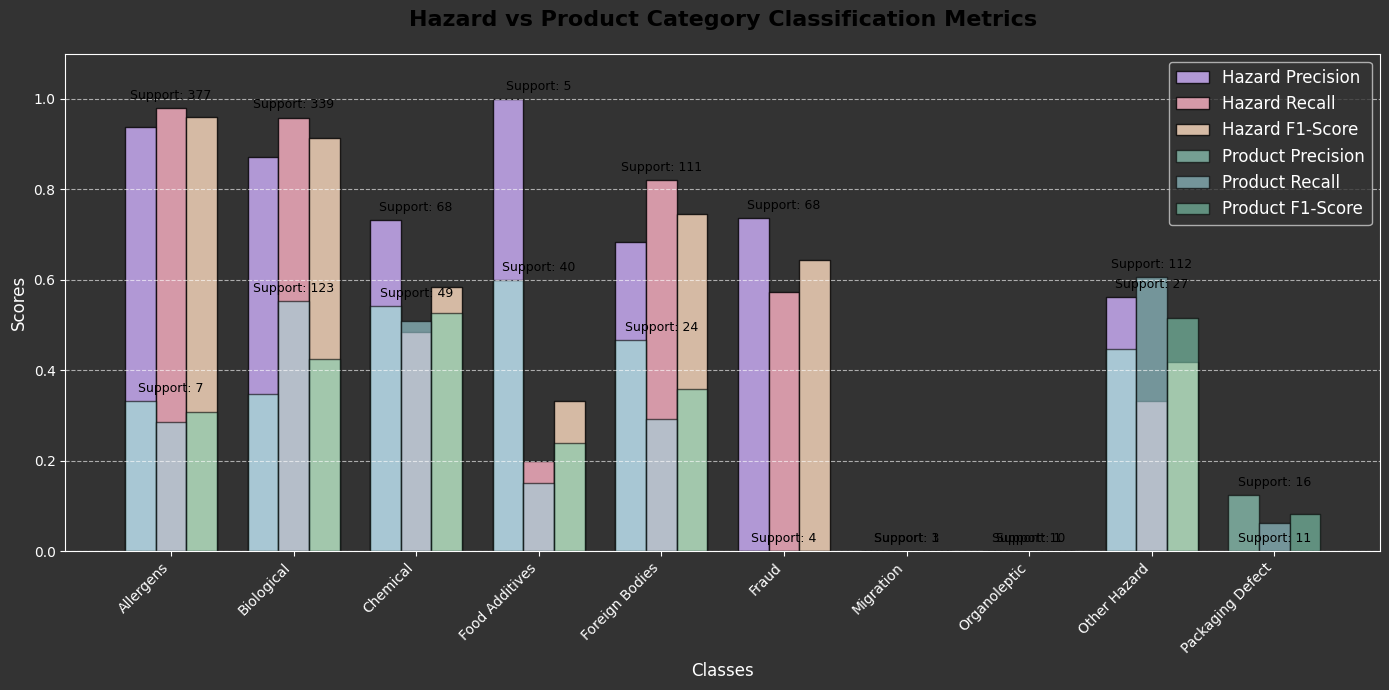

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Hazard Category classification metrics
hazard_data = {
    'classes': ['Allergens', 'Biological', 'Chemical', 'Food Additives', 'Foreign Bodies', 'Fraud', 
                'Migration', 'Organoleptic', 'Other Hazard', 'Packaging Defect'],
    'precision': [0.939, 0.871, 0.733, 1.0, 0.684, 0.736, 0.0, 0.0, 0.563, 0.0],
    'recall': [0.981, 0.959, 0.485, 0.2, 0.82, 0.574, 0.0, 0.0, 0.333, 0.0],
    'f1_score': [0.96, 0.913, 0.584, 0.333, 0.746, 0.645, 0.0, 0.0, 0.419, 0.0],
    'support': [377, 339, 68, 5, 111, 68, 1, 10, 27, 11]
}

# Data for Product Category classification metrics
product_data = {
    'classes': ['Alcoholic Beverages', 'Cereals & Bakery', 'Cocoa & Coffee', 'Confectionery', 'Dietetic Foods',
                'Fats & Oils', 'Feed Materials', 'Food Contact Materials', 'Fruits & Vegetables', 'Herbs & Spices'],
    'precision': [0.333, 0.347, 0.543, 0.6, 0.467, 0.0, 0.0, 0.0, 0.447, 0.125],
    'recall': [0.286, 0.553, 0.51, 0.15, 0.292, 0.0, 0.0, 0.0, 0.607, 0.063],
    'f1_score': [0.308, 0.426, 0.526, 0.24, 0.359, 0.0, 0.0, 0.0, 0.515, 0.083],
    'support': [7, 123, 49, 40, 24, 4, 3, 1, 112, 16]
}

# Plotting a comparison between Hazard and Product Category Metrics
def plot_comparison_metrics(hazard_data, product_data, title="Hazard vs Product Category Classification Metrics"):
    x = np.arange(len(hazard_data['classes']))  # Class positions
    width = 0.25  # Width of the bars

    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Define aesthetic colors for bars
    hazard_colors = ['#D1B2FF', '#FFB3C6', '#FFDDC1']  # Soft lavender, pink, peach for hazard
    product_colors = ['#A2E8D4', '#A1D7E0', '#80D0B3']  # Soft mint green, aqua blue, teal for product

    # Plotting Hazard Category
    ax.bar(x - width, hazard_data['precision'], width, label='Hazard Precision', color=hazard_colors[0], edgecolor='black', alpha=0.8)
    ax.bar(x, hazard_data['recall'], width, label='Hazard Recall', color=hazard_colors[1], edgecolor='black', alpha=0.8)
    ax.bar(x + width, hazard_data['f1_score'], width, label='Hazard F1-Score', color=hazard_colors[2], edgecolor='black', alpha=0.8)

    # Plotting Product Category
    ax.bar(x - width, product_data['precision'], width, label='Product Precision', color=product_colors[0], edgecolor='black', alpha=0.6)
    ax.bar(x, product_data['recall'], width, label='Product Recall', color=product_colors[1], edgecolor='black', alpha=0.6)
    ax.bar(x + width, product_data['f1_score'], width, label='Product F1-Score', color=product_colors[2], edgecolor='black', alpha=0.6)

    # Annotating support values above the bars
    for i, support in enumerate(hazard_data['support']):
        ax.text(i, max(hazard_data['precision'][i], hazard_data['recall'][i], hazard_data['f1_score'][i]) + 0.02, 
                f"Support: {support}", ha='center', fontsize=9, color='black')
    
    for i, support in enumerate(product_data['support']):
        ax.text(i, max(product_data['precision'][i], product_data['recall'][i], product_data['f1_score'][i]) + 0.02, 
                f"Support: {support}", ha='center', fontsize=9, color='black')

    # Formatting
    ax.set_title(title, fontsize=16, fontweight='bold', color='black', pad=20)
    ax.set_ylabel('Scores', fontsize=12)
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(hazard_data['classes'], rotation=45, ha='right')
    ax.set_ylim(0, 1.1)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Generate the comparison plot for Hazard vs Product Category
plot_comparison_metrics(hazard_data, product_data)


### Combined Score for Hazard Category and Product Category Prediction

The **Combined Score** achieved for predicting both the **Hazard Category** and the **Product Category** simultaneously is **0.3902**. This metric evaluates the model's overall ability to perform well on both tasks using the harmonic mean of their individual macro F1-scores. 


#### Interpretation:
1. **Decent Performance**:
   - The score reflects a moderate ability of the model to predict hazard and product categories accurately. 
   - However, there's room for improvement, especially in handling less frequent categories where the model struggles the most.

2. **Class Dependencies**:
   - The model's performance is influenced by dependencies between **hazard categories** and **product categories**. Misclassifications in one may lead to cascading errors in the combined evaluation.

3. **Challenges in Rare Classes**:
   - Classes with limited data or imbalanced distributions contribute to the lower combined score, emphasizing the need for strategies like class rebalancing or feature enrichment.

This combined score highlights the importance of balancing performance across all classes to ensure a fair and robust model for real-world applications.


In [ ]:
# Compute the combined score for Subtask 1 `Text`
combined_score_text_st1 = compute_score(
    y_test_text_hazard_cat, y_test_text_product_cat, 
    y_pred_hazard_cat.flatten(), y_pred_product_cat.flatten())

print(f"Combined Score for Hazard Category and Product Category Prediction: {combined_score_text_st1}")

Combined Score for Hazard Category and Product Category Prediction: 0.3902355210617526


### Prediction on Validation Data (Subtask 1)

In this section, we use the **best-trained model** for hazard category and product category predictions on the validation dataset. The predictions are stored for evaluation and submission purposes.

#### Process:
1. **Hazard Category Prediction**:
   - The `best_model_product_cat` is utilized to predict the hazard category labels on the validation text dataset (`X_val_text`).

2. **Product Category Prediction**:
   - Similarly, the same model predicts product category labels for the validation dataset.

3. **Submission Preparation**:
   - The predictions for hazard and product categories are compiled into a DataFrame for submission in the required format.


In [ ]:
# Predict hazard-category on validation data text
val_predictions_hazard_cat = best_model_product_cat.predict(X_val_text)

# Predict product-category on validation data text
val_predictions_product_cat = best_model_product_cat.predict(X_val_text)

In [ ]:
submission_CB_st1_text = pd.DataFrame({
    'hazard-category': val_predictions_hazard_cat.flatten(),
    'product-category': val_predictions_product_cat.flatten()
})


In [ ]:
submission_CB_st1_text.to_csv('submission_CB_st1_text.csv', index=False)

### Hazard Prediction Results

#### Model Training Overview:
- **Best Parameters**: 
  - Learning Rate: 0.1
  - Iterations: 200
  - Depth: 8
- **Macro F1 Score**: 0.1822

#### Performance Insights:
The **Macro F1 Score** of 0.1822 indicates challenges in classifying certain hazard categories. This is evident in the **classification report**, where several classes exhibit:
- **Precision** and **Recall** scores of 0, particularly for underrepresented categories (e.g., "Aflatoxin," "Alcohol Content," and "Alkaloids").
- A few categories, like "Almond," show moderate performance, with an F1-Score of 0.3871.



In [ ]:
# Train and evaluate for Hazard Prediction
best_model_hazard, f1_hazard, y_pred_hazard = train_evaluate_catboost(
    X_train_text_hazard, y_train_text_hazard, X_test_text_product, y_test_text_hazard, param_grid, "Hazard Prediction"
)

/home/lefki/msc/practical_data_science/semeval/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/lefki/msc/practical_data_science/semeval/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 3.5703363	total: 747ms	remaining: 2m 28s
0:	learn: 3.5194653	total: 3.88s	remaining: 12m 51s
0:	learn: 3.5740758	total: 3.98s	remaining: 13m 11s
0:	learn: 3.8343273	total: 25.1s	remaining: 1h 23m 19s
0:	learn: 3.9093894	total: 26.7s	remaining: 1h 28m 38s
0:	learn: 3.8524897	total: 27.9s	remaining: 1h 32m 31s
100:	learn: 1.2803496	total: 4m 29s	remaining: 4m 24s
100:	learn: 1.2844119	total: 4m 27s	remaining: 4m 22s
100:	learn: 1.2888821	total: 4m 29s	remaining: 4m 24s
199:	learn: 0.9804020	total: 8m 48s	remaining: 0us
199:	learn: 1.0098193	total: 8m 50s	remaining: 0us
199:	learn: 0.9963934	total: 8m 54s	remaining: 0us
100:	learn: 1.1016581	total: 20m 44s	remaining: 20m 20s
100:	learn: 1.0678324	total: 20m 47s	remaining: 20m 22s
100:	learn: 1.0883297	total: 20m 50s	remaining: 20m 25s
199:	learn: 0.7668093	total: 35m 5s	remaining: 0us
199:	learn: 0.7294902	total: 35m 9s	remaining: 0us
199:	learn: 0.7243879	total: 35m 11s	remaining: 0us
0:	learn: 3.6702158	total: 4.08s	remaining:

#### Classification Report:
#### Observations:
1. **Class Imbalance**: The low F1 scores for many classes reflect an imbalance in the dataset, with some hazard types having very few samples (e.g., "Alcohol Content" with only 1 instance).
2. **Weighted Average Performance**: A weighted F1-Score of 0.6110 suggests that the model performs better on the more common classes.

#### Challenges:
This result highlights the need for more robust strategies to handle the inherent difficulty of classifying rare categories in highly imbalanced datasets.


In [ ]:
# Generate a classification report for Hazard (Text)
classification_report_hazard = classification_report(
    y_test_text_hazard,
    y_pred_hazard,
    zero_division=0,
    output_dict=True
)

# Convert the classification report to a DataFrame for better visualization
classification_report_hazard = pd.DataFrame(classification_report_hazard).transpose()

classification_report_hazard

,precision,recall,f1-score,support
Aflatoxin,0.000000,0.000000,0.000000,4.000000
alcohol content,0.000000,0.000000,0.000000,1.000000
alkaloids,0.000000,0.000000,0.000000,2.000000
allergens,0.000000,0.000000,0.000000,4.000000
almond,0.352941,0.428571,0.387097,14.000000
...,...,...,...,...
virus,0.000000,0.000000,0.000000,1.000000
walnut,0.250000,0.200000,0.222222,5.000000
accuracy,0.659784,0.659784,0.659784,0.659784
macro avg,0.187559,0.189147,0.182236,1017.000000


### Product Prediction Results

#### Model Training Overview:
- **Best Parameters**: 
  - Learning Rate: 0.1
  - Iterations: 100
  - Depth: 4
- **Macro F1 Score**: 0.02697

#### Performance Insights:
The **Macro F1 Score** of 0.02697 highlights significant challenges in predicting product categories, especially for underrepresented classes. The **classification report** indicates:
- **Zero Precision and Recall** for a majority of product categories, signaling the model's inability to correctly classify these classes.
- Some improvement for specific classes such as "Fishes not identified," with an F1-Score of 0.125, despite overall poor performance.



In [ ]:
# Train and evaluate for Product Prediction
best_model_product, f1_product, y_pred_product = train_evaluate_catboost_product(
    X_train_text_product, y_train_text_product, X_test_text_product, y_test_text_product, param_grid, "Product Prediction"
)

/home/lefki/msc/practical_data_science/semeval/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/lefki/msc/practical_data_science/semeval/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 6.5136632	total: 4.32s	remaining: 7m 7s
0:	learn: 6.5173257	total: 4.39s	remaining: 7m 14s
0:	learn: 6.4813867	total: 4.44s	remaining: 7m 19s
10:	learn: 5.7534034	total: 45.7s	remaining: 6m 9s
10:	learn: 5.7814909	total: 46.3s	remaining: 6m 14s
10:	learn: 5.7478889	total: 46.4s	remaining: 6m 15s
20:	learn: 5.3956431	total: 1m 27s	remaining: 5m 30s
20:	learn: 5.4237845	total: 1m 28s	remaining: 5m 33s
20:	learn: 5.4489094	total: 1m 28s	remaining: 5m 34s
30:	learn: 5.1604267	total: 2m 10s	remaining: 4m 51s
30:	learn: 5.2174862	total: 2m 12s	remaining: 4m 54s
30:	learn: 5.1961130	total: 2m 12s	remaining: 4m 54s
40:	learn: 4.9604881	total: 2m 50s	remaining: 4m 5s
40:	learn: 5.0200671	total: 2m 53s	remaining: 4m 9s
40:	learn: 4.9974961	total: 2m 58s	remaining: 4m 16s
50:	learn: 4.8015893	total: 3m 32s	remaining: 3m 24s
50:	learn: 4.8565212	total: 3m 37s	remaining: 3m 28s
50:	learn: 4.8265137	total: 3m 41s	remaining: 3m 32s
60:	learn: 4.6333052	total: 4m 13s	remaining: 2m 42s
60:	le

#### Classification Report:

#### Observations:
1. **Severe Class Imbalance**: 
   - Many classes lack sufficient support, leading to poor generalization for minority classes.
2. **Overall Low Performance**:
   - Weighted averages of precision and recall are low, reflecting the model's difficulty in handling the diversity of product categories.

#### Recommendations:
- **Class Balancing**:
  - Employ techniques such as oversampling, undersampling, or class weights during training to address imbalance.
- **Feature Engineering**:
  - Incorporate additional features or improve preprocessing to better capture the nuances of product categories.
- **Model Adjustments**:
  - Experiment with deeper architectures or ensemble methods to potentially boost performance for difficult classes.
- **Focus on Rare Classes**:
  - Investigate techniques like SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic data for rare categories.

#### Challenges:
This result reflects the inherent difficulty of classifying a highly imbalanced dataset with many product categories and the need for advanced strategies to improve the model's performance.


In [ ]:
# Generate a classification report for Product (Text)
classification_report_product = classification_report(
    y_test_text_product,
    y_pred_product,
    zero_division=0,
    output_dict=True
)

# Convert the classification report to a DataFrame for better visualization
classification_report_product = pd.DataFrame(classification_report_product).transpose()

classification_report_product

,precision,recall,f1-score,support
Catfishes (freshwater),0.000000,0.000000,0.000000,5.000000
Fishes not identified,0.071429,0.500000,0.125000,6.000000
Not classified pork meat,0.000000,0.000000,0.000000,3.000000
Pangas catfishes (generic),0.000000,0.000000,0.000000,1.000000
Precooked cooked pork meat products,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...
wraps,0.000000,0.000000,0.000000,4.000000
yoghurt,0.000000,0.000000,0.000000,5.000000
accuracy,0.163225,0.163225,0.163225,0.163225
macro avg,0.029803,0.041437,0.026966,1017.000000


### Combined Score and Submission for Subtask 2 (Text)

In this section, we compute the **combined score** for hazard and product predictions on the test set and prepare predictions for submission based on validation data.

#### Process:

1. **Compute Combined Score**:
   - The combined score evaluates both hazard and product predictions using the `compute_score` function.
   - The `compute_score` function computes the macro F1 scores for hazard and product predictions and averages them for a final score.

2. **Predictions on Validation Data**:
   - Predictions for hazard and product categories are generated using the `best_model_product` on the validation text dataset (`X_val_text`).

3. **Submission Preparation**:
   - A DataFrame is created with columns `hazard` and `product` containing the respective predictions.
   - The DataFrame is saved as a CSV file in the required submission format.

#### Results:
- **Combined Score for Hazard and Product Prediction:** 0.1087
This score indicates the overall performance of the model on both hazard and product predictions.
While relatively low, it highlights areas for further optimization or improvement in future iterations.

In [ ]:
# Compute the combined score for Subtask 21 `Text`
combined_score_text_st2 = compute_score(
    y_test_text_hazard, y_test_text_product, 
    y_pred_hazard.flatten(), y_pred_product.flatten())

print(f"Combined Score for Hazard and Product Prediction: {combined_score_text_st2}")


Combined Score for Hazard and Product Prediction: 0.10868719060824167


# Insights from Combined Score Comparison (Hazard vs Product Prediction)

### **Overview:**
The pie chart compares the combined scores of two key tasks in the **Food Hazard Detection Challenge**: **Hazard Prediction** and **Product Prediction**. The scores represent the performance of a **CatBoost model** trained to classify food hazards and product categories. The chart provides a visual comparison of how well the model performed in predicting these categories, based on the calculated combined score.

### **Combined Score Results:**
- **Hazard Prediction**: **0.1087**  
  The model performed with a combined score of **10.87%** for hazard prediction. This indicates relatively poor performance in identifying specific hazards in the food recall reports. Low support for certain hazard categories and class imbalance might have contributed to this result.
  
- **Product Prediction**: **0.3902**  
  The model performed significantly better on product prediction, achieving a combined score of **39.02%**. This suggests that the model has a better ability to identify and classify food products than hazards. However, the performance is still far from ideal, likely due to similar challenges such as class imbalance and insufficient data for certain product categories.

### **Visual Insights:**
The **pie chart** presents these insights visually, using **pastel colors** to differentiate between the two tasks. The chart emphasizes the disparity in performance between hazard and product prediction, with **hazard prediction** making up a smaller proportion of the combined score, while **product prediction** contributes significantly more to the overall score.



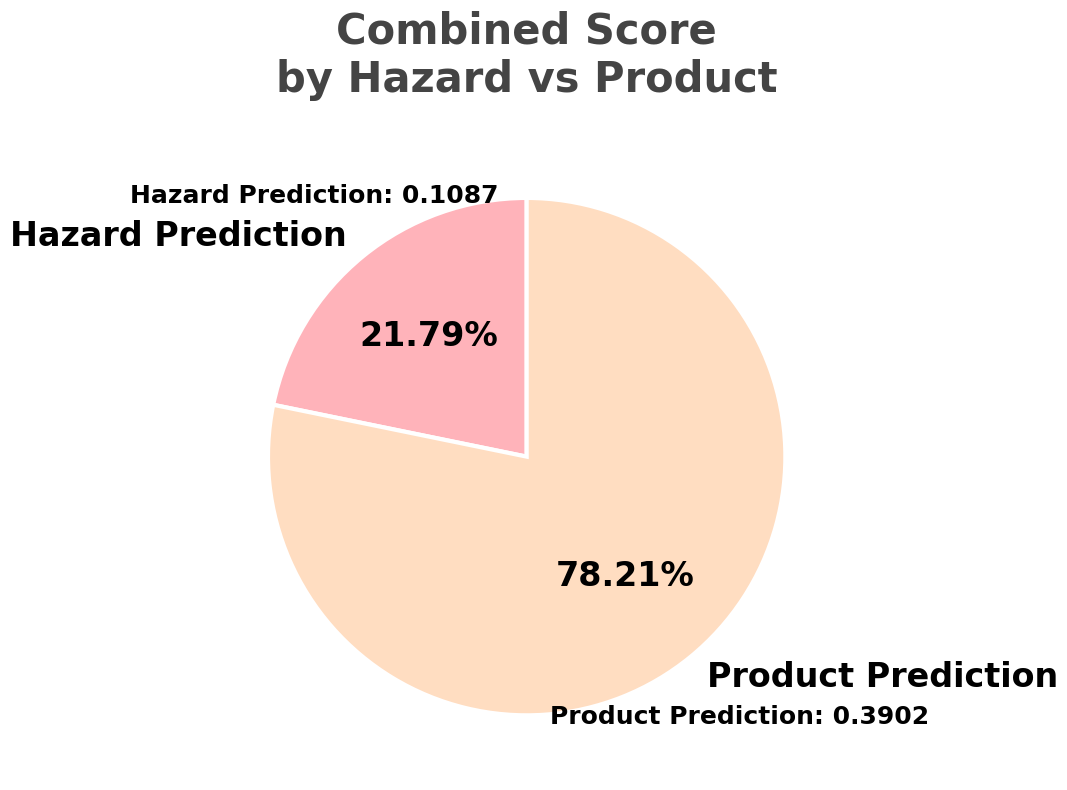

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the pie chart (combined scores for hazard and product prediction)
tasks = ['Hazard Prediction', 'Product Prediction']
scores = [0.1087, 0.3902]

# Define pastel color palette
colors = ['#FFB3BA', '#FFDDC1']  # Soft pastel pink and pastel peach

# Create a circular pie chart with a hole (doughnut style)
fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(scores, labels=tasks, autopct='%1.2f%%', startangle=90,
                                  colors=colors, wedgeprops={'edgecolor': 'white', 'linewidth': 2},
                                  textprops={'fontsize': 20, 'fontweight': 'bold', 'color': 'black'})

# Add shadows to the wedges for a 3D effect
for wedge in wedges:
    wedge.set_edgecolor('white')
    wedge.set_linewidth(3)

# Add a bold title with a slight shadow effect
plt.title('Combined Score Comparison\n(Hazard vs Product)', fontsize=32, fontweight='bold', color='#444444', pad=50)

# Customize the text and labels with pastel tones and shadow effects
for autotext in autotexts:
    autotext.set_fontsize(24)
    autotext.set_fontweight('bold')
    autotext.set_color('black')

for text in texts:
    text.set_fontsize(24)
    text.set_fontweight('bold')
    text.set_color('black')

# Add custom text annotations manually using the angle of each wedge
angles = [wedge.theta1 + (wedge.theta2 - wedge.theta1) / 2 for wedge in wedges]

# Position the text annotations around the pie chart, with some tweaks for a cleaner look
for i, (score, angle) in enumerate(zip(scores, angles)):
    # Calculate the position of the annotation with a little offset for better spacing
    x = np.cos(np.radians(angle)) * 1.3  # Slightly increased distance from the center
    y = np.sin(np.radians(angle)) * 1.3
    ax.text(x, y, f'{tasks[i]}: {score:.4f}', ha='center', va='center', fontsize=18, fontweight='bold', color='black')

# Use a gradient background for the chart
ax.set_facecolor('#F9F9F9')

# Add some space and give the chart a 3D effect by offsetting the wedges
ax.set_title('Combined Score\nby Hazard vs Product', fontsize=30, fontweight='bold', color='#444444', pad=30)

# Show the plot
plt.tight_layout()
plt.show()


#### Submission File:
The submission_CB_st2_text.csv file is ready for evaluation and contains:

- **hazard:** Predicted hazard labels.
- **product:** Predicted product labels.

In [ ]:
# Predict hazard-category on validation data text
val_predictions_hazard = best_model_product.predict(X_val_text)

# Predict product-category on validation data text
val_predictions_product = best_model_product.predict(X_val_text)
submission_CB_st2_text = pd.DataFrame({
    'hazard': val_predictions_hazard.flatten(),
    'product': val_predictions_product.flatten()
})
submission_CB_st2_text.to_csv('submission_CB_st2_text.csv', index=False)

# Combined Score Comparison: Titles vs Texts

### **Combined Score for Hazard and Product Prediction:**
- **Titles**: **0.0989 (9.89%)**  
  The model performed poorly in hazard and product prediction using titles, likely due to the limited context in the short text.

- **Texts**: **0.1087 (10.87%)**  
  A slight improvement over titles, but still low, indicating that more context is needed to make accurate predictions.

### **Combined Score for Hazard Category and Product Category Prediction:**
- **Titles**: **0.3176 (31.76%)**  
  While the performance improves when predicting categories rather than exact hazards and products, the result is still quite low for titles.

- **Texts**: **0.3902 (39.02%)**  
  Full-text reports show a better performance in predicting hazard and product categories compared to titles.

#### **Conclusion:**
In this comparison, texts clearly outperform titles in hazard and product prediction, as well as in predicting hazard and product categories. However, both approaches still exhibit significant challenges. To achieve higher accuracy, further optimization, model refinement, and data augmentation will be crucial.


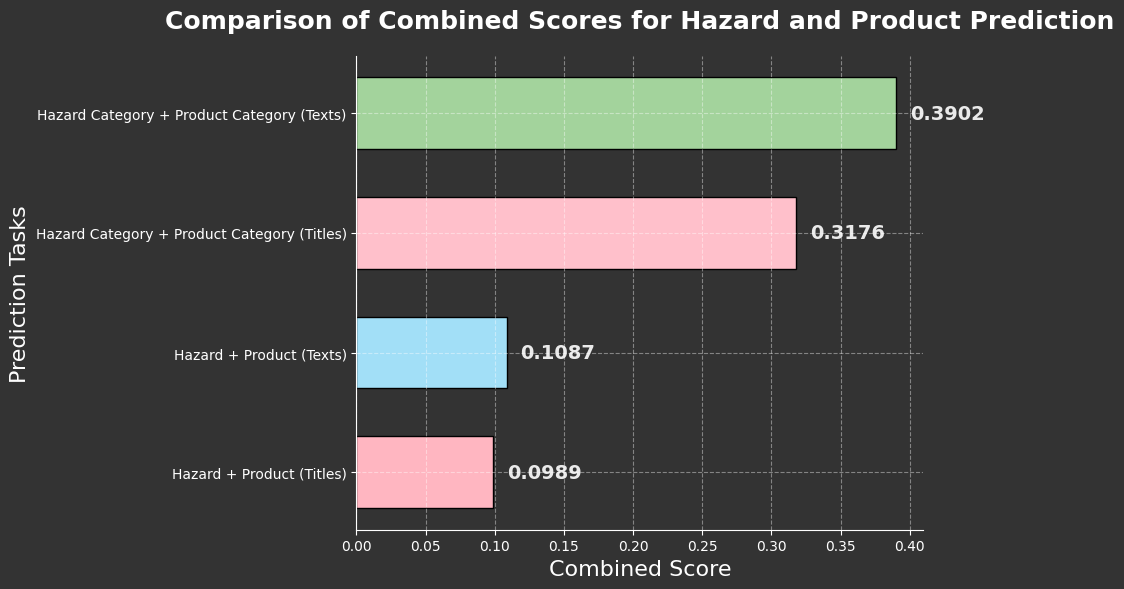

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
categories = ['Hazard + Product (Titles)', 'Hazard + Product (Texts)', 
              'Hazard Category + Product Category (Titles)', 'Hazard Category + Product Category (Texts)']
scores = [0.0989, 0.1087, 0.3176, 0.3902]  # Combined Scores

# Define custom colors (pastel shades for elegance)
colors = ['#FFB6C1', '#A2DFF7', '#FFC0CB', '#A3D39C'] 

# Set dark grey background
plt.rcParams['axes.facecolor'] = '#333333'  # Dark grey background
plt.rcParams['figure.facecolor'] = '#333333'  # Dark grey for the figure as well
plt.rcParams['axes.edgecolor'] = 'white'  # White edges for contrast
plt.rcParams['grid.color'] = 'white'  # White gridlines

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Creating the bar plot
bars = ax.barh(categories, scores, color=colors, edgecolor="black", height=0.6)

# Annotate the scores with white text for better visibility on dark background
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
            va='center', ha='left', fontsize=14, fontweight='bold', color='white', alpha=0.9)

# Add titles and labels with light colors
ax.set_title('Comparison of Combined Scores for Hazard and Product Prediction', 
             fontsize=18, fontweight='bold', color='white', pad=20)

ax.set_xlabel('Combined Score', fontsize=16, color='white')
ax.set_ylabel('Prediction Tasks', fontsize=16, color='white')

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.4)

# Remove spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.tight_layout()
plt.show()
